# Trial Onset

In [1]:
import matplotlib
# matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import mat73
import re
from neurodsp.timefrequency import compute_wavelet_transform
from BCI2kReader import BCI2kReader as b2k
import os
import mne
from tabulate import tabulate
import IPython
import seaborn as sns
import scipy
import joblib
import dask.array as da 


import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest

# Import required code for visualizing example models
from fooof import FOOOF
from fooof.sim.gen import gen_power_spectrum
from fooof.sim.utils import set_random_seed
from fooof.plts.spectra import plot_spectra
from fooof.plts.annotate import plot_annotated_model
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series
from neurodsp.spectral import compute_spectrum, rotate_powerlaw
from neurodsp.plts.spectral import plot_power_spectra

%config Completer.use_jedi = False

In [2]:
def log_and_zscore_TFR(TFR, baseline, logflag = True):
    """
    TFR:                        Transformed and log transformed data from compute_TFR
    logflag:                    Log transform or not, defaults to True
    baseline:                   tuple that specifies the time in seconds that baseline should be calculated on 
                                (should be 1-2s smaller than epoch TFR was calculated on to exclude artifacts on morlet waves
    """
    if logflag:
        print('log transforming')
        TFR.data = da.from_array(TFR.data, chunks="auto")  # Convert the data to a Dask array
        TFR.data = da.log(TFR.data)  # Compute the element-wise log
    
    print('z-scoring to baseline')
    bix = [a and b for a, b in zip(TFR.times >= baseline[0], TFR.times <= baseline[1])]
    bmean = TFR.data[:, :, :, bix].mean(axis=3, keepdims=True).mean(axis=0, keepdims=True)
    bstd = TFR.data[:, :, :, bix].std(axis=3, keepdims=True).std(axis=0, keepdims=True)
    TFR.data = (TFR.data - bmean) / bstd

    TFR.data = TFR.data.compute()  # Convert the Dask array back to a NumPy array
    return TFR

def calculate_trial_onset_average(sub_list, string_filter, roi, base = (-1,5)):
    tfrs = []
    no_tfrs = []
    for subject in sub_list:

        # load data
        tmp_TFR = mne.time_frequency.read_tfrs(f"/home/brooke/pacman/preprocessing/{subject}/ieeg/trial_onset/{roi}-tfr.h5")
        
        # check if metadata exists
        if tmp_TFR[0].metadata is None:

            # load old pres data to help add metadata
            trial_onset_epochs = mne.read_epochs(f"/home/brooke/pacman/preprocessing/{subject}/ieeg/{subject}_bp_clean_pres-locked_ieeg.fif")

            # get good epochs (for behavioral data only)
            good_epochs = [i for i,x in enumerate(trial_onset_epochs.get_annotations_per_epoch()) if not x]

            # Create trial metadata 
            trial_data = pd.read_csv(f"/home/brooke/pacman/raw_data/{subject}/behave/{subject}_raw_behave.csv")
            trial_data['Trial'] = trial_data['Trial'] - 1
            trial_data['TrialType'] = trial_data.groupby('Trial')['TrialType'].transform(lambda x: x.mode().iloc[0])
            trial_data = trial_data[['Trial', 'TrialType']].drop_duplicates()
            trial_data = trial_data[trial_data['Trial'] >=0]
            trial_data = trial_data[trial_data['Trial'].isin(good_epochs)]

            # last trial is fake for BJH021
            if subject == 'BJH021' or subject == 'LL10' or subject == "LL13":
                tmp_TFR[0] = tmp_TFR[0][0:-1]

            # set metadata to TFR
            tmp_TFR[0].metadata = trial_data
            
            # save
            tmp_TFR[0].save(f"/home/brooke/pacman/preprocessing/{subject}/ieeg/trial_onset/{roi}-tfr.h5", overwrite = True)
         
        # log and zscore
        tmp_TFR = log_and_zscore_TFR(tmp_TFR[0], baseline = base, logflag=True)
            
        
        # filter
        tfr_case = tmp_TFR[string_filter]

        # get mean and append
        tfrs.append(tfr_case.data.mean(axis = 0).mean(axis = 0))
        
    
    if any("LL" in subject for subject in sub_list):

        # get indicies of high/low samp rate subs
        first_ll_sub = [subject for subject in sub_list if "LL" in subject][0]
        ll_begin = sub_list.index(first_ll_sub)

        # high sampling rate
        washu_tfrs = np.asarray(tfrs[0:ll_begin])
        washu_tfrs_mean = washu_tfrs.mean(axis = 0)

        # Low sampling rate
        ll_tfrs = np.asarray(tfrs[ll_begin:])
        ll_tfrs_mean = ll_tfrs.mean(axis = 0)

        # combine
        all_subs_tfrs = np.stack((washu_tfrs_mean[:, ::2], ll_tfrs_mean[:, 0:3001]))
      
        # mean
        all_subs_average = all_subs_tfrs.mean(axis = 0)
        
    else:
        
        # high sampling rate
        washu_tfrs = np.asarray(tfrs)
        washu_tfrs_mean = washu_tfrs.mean(axis = 0)

        # mean
        all_subs_average = washu_tfrs_mean
        

    return all_subs_average

def plot_allsub_averages(array_average, title, fname):
    plt.rcParams['figure.figsize'] = [45, 35]
    plt.rcParams.update({'font.size': 38})
    matplotlib.rcParams['font.serif'] = 'Times New Roman'
    matplotlib.rcParams['font.family'] = 'serif'

    freqs = np.logspace(start = np.log10(1), stop = np.log10(150), num = 80, base = 10, endpoint = True)
    yticks = np.linspace(np.min(freqs),np.max(freqs),len(freqs))
    yticks_labels = np.round(freqs, 1)

    fig, ax = plt.subplots()
    i = ax.imshow(array_average, cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]], vmin = -1, vmax = 1)
    i2 = plt.axvline(x=0, color='black', linestyle='--')
    ax.set_yticks(yticks[::2])
    ax.set_yticklabels(yticks_labels[::2])
    bar = plt.colorbar(i)
    ax.set_title(title, fontsize=65, fontweight = "bold", pad=40)
    fig.savefig(fname, dpi=400)

## Hippocampus

In [3]:
sub_list = ['SLCH002', 'BJH016', 'BJH025', 'BJH021', 'LL10', 'LL12', 'LL13']

all_subs_average_hc_ghost = calculate_trial_onset_average(sub_list, 'TrialType <= 16', 'hc')
all_subs_average_hc_noghost = calculate_trial_onset_average(sub_list, 'TrialType > 16', 'hc')
    

Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/trial_onset/hc-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/BJH016/ieeg/trial_onset/hc-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/BJH025/ieeg/trial_onset/hc-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/BJH021/ieeg/trial_onset/hc-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/LL10/ieeg/trial_onset/hc-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/LL12/ieeg/trial_onset/hc-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/LL13/ieeg/trial_onset/hc-tfr.h5 ...
Adding metadata with 2 co

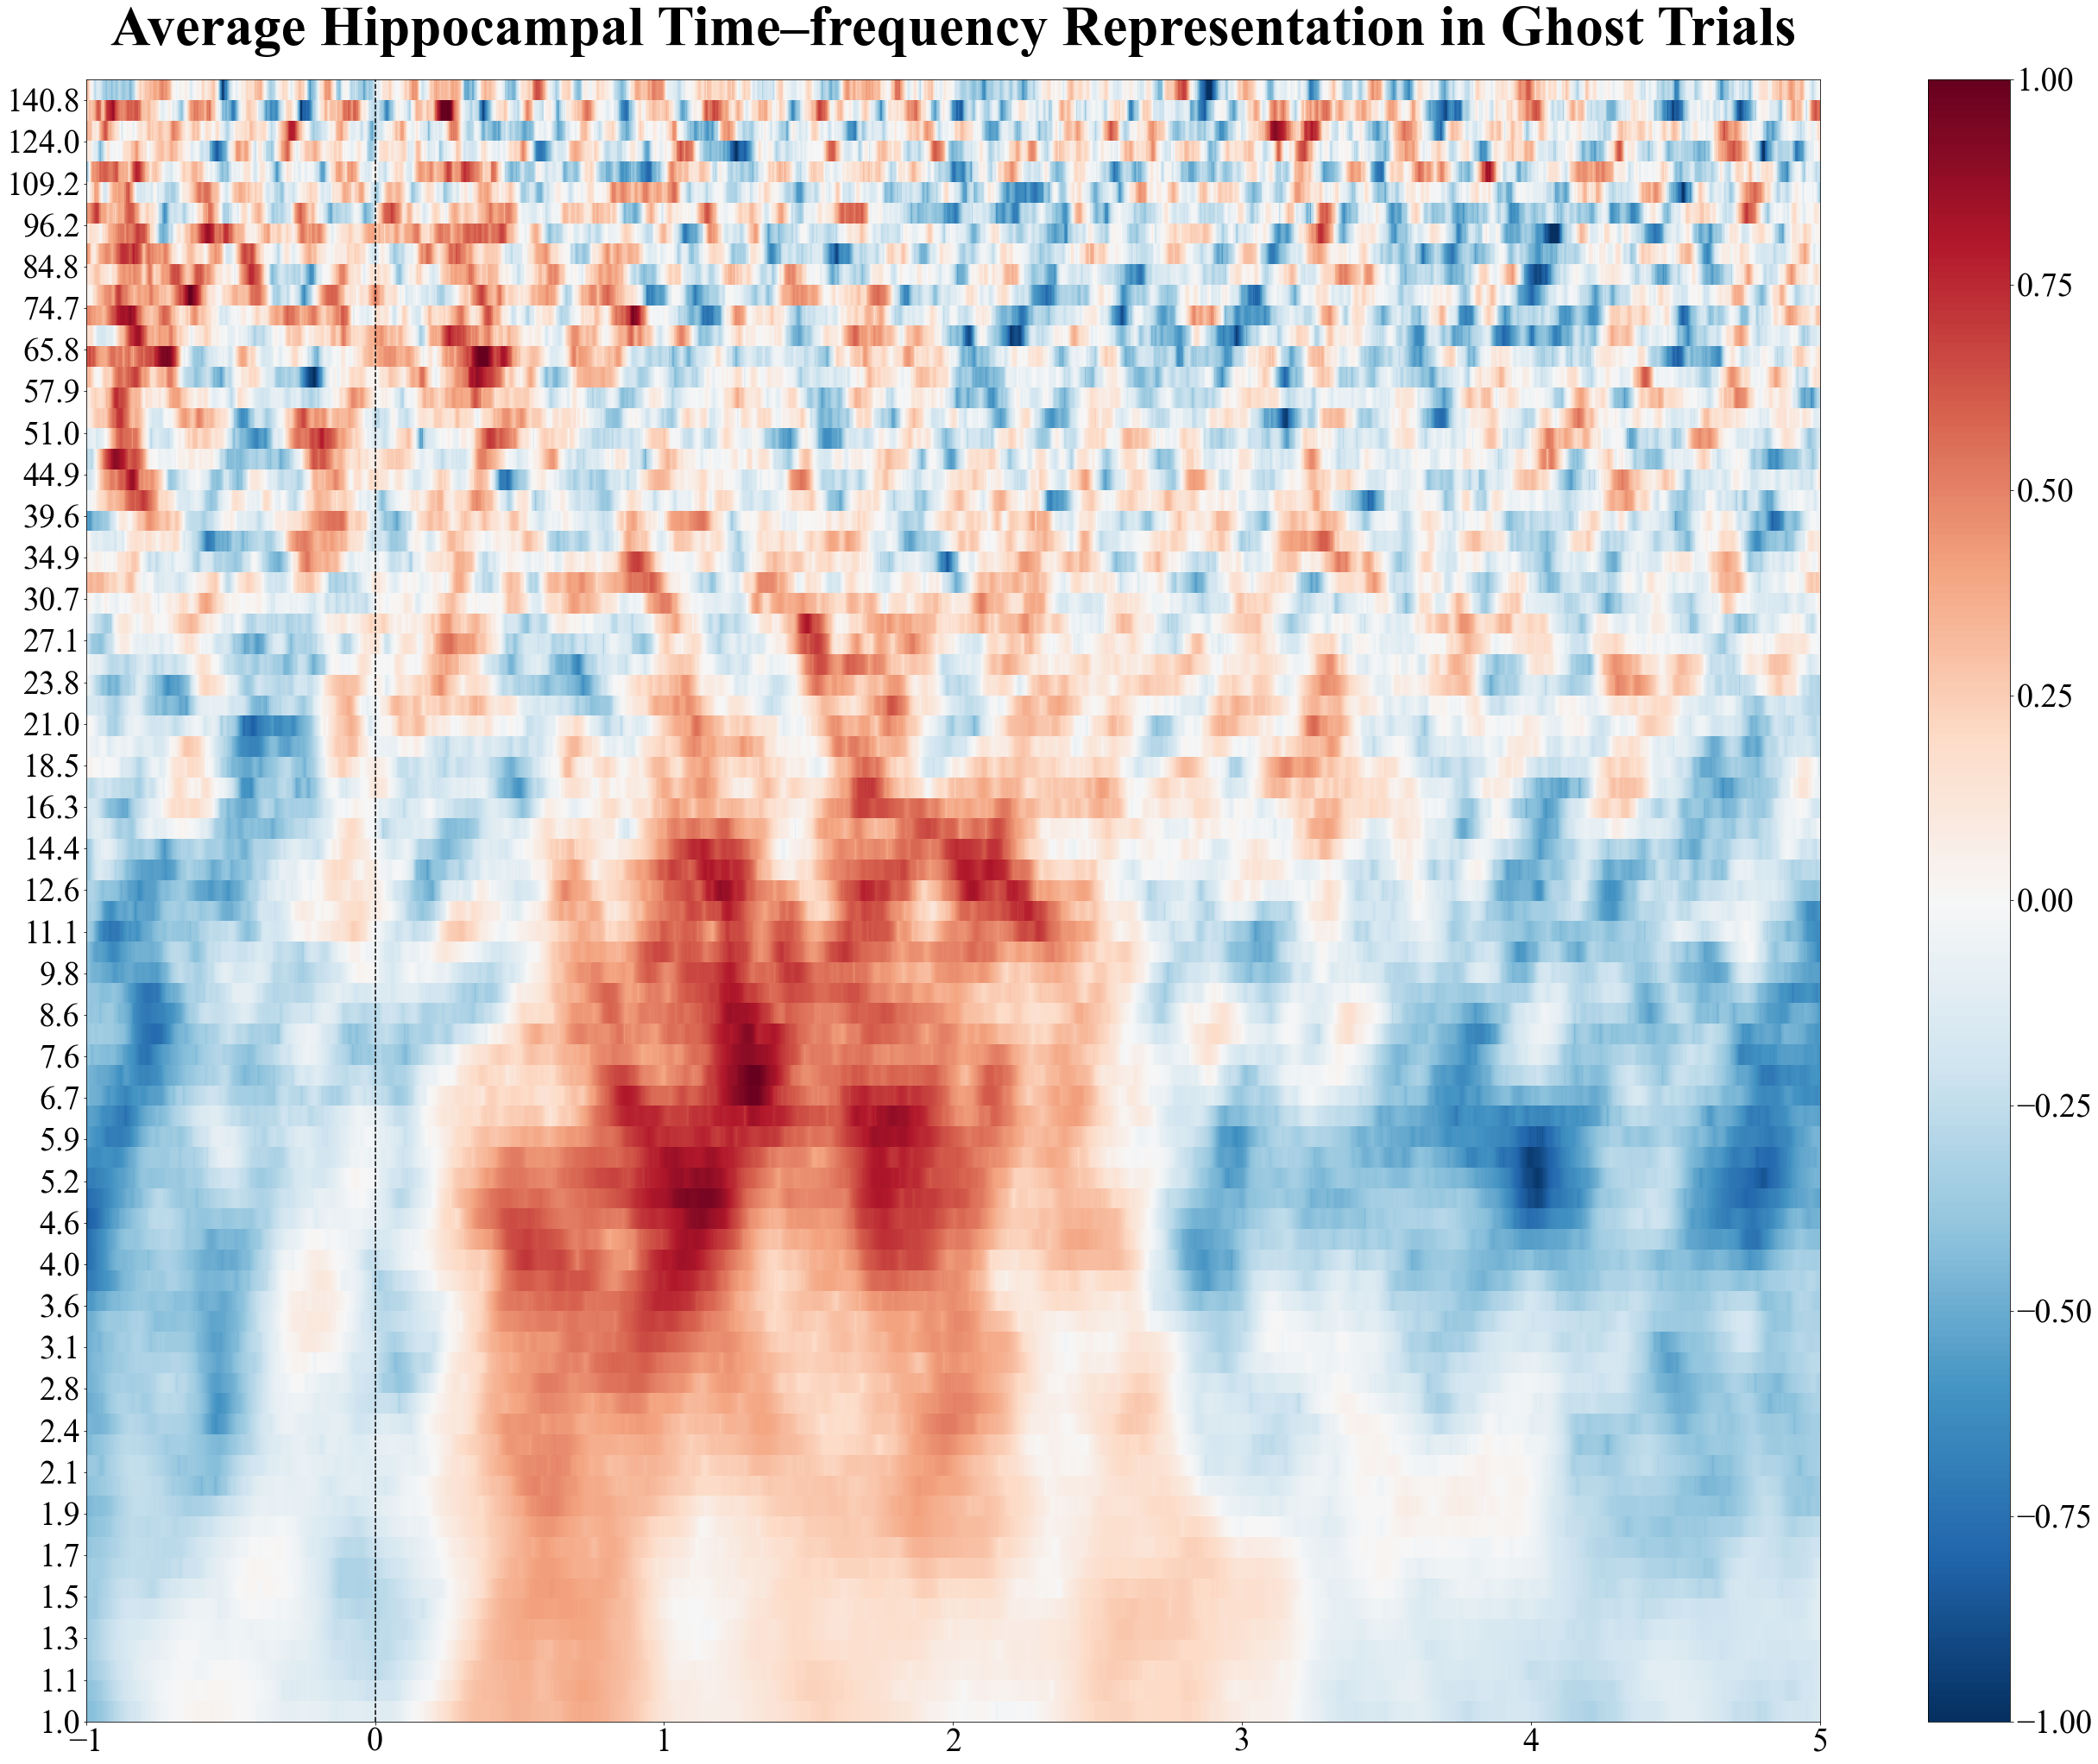

In [24]:
plot_allsub_averages(all_subs_average_hc_ghost, "Average Hippocampal Time–frequency Representation in Ghost Trials", 'average_hc_ghosttrialonset_all_subs.png')


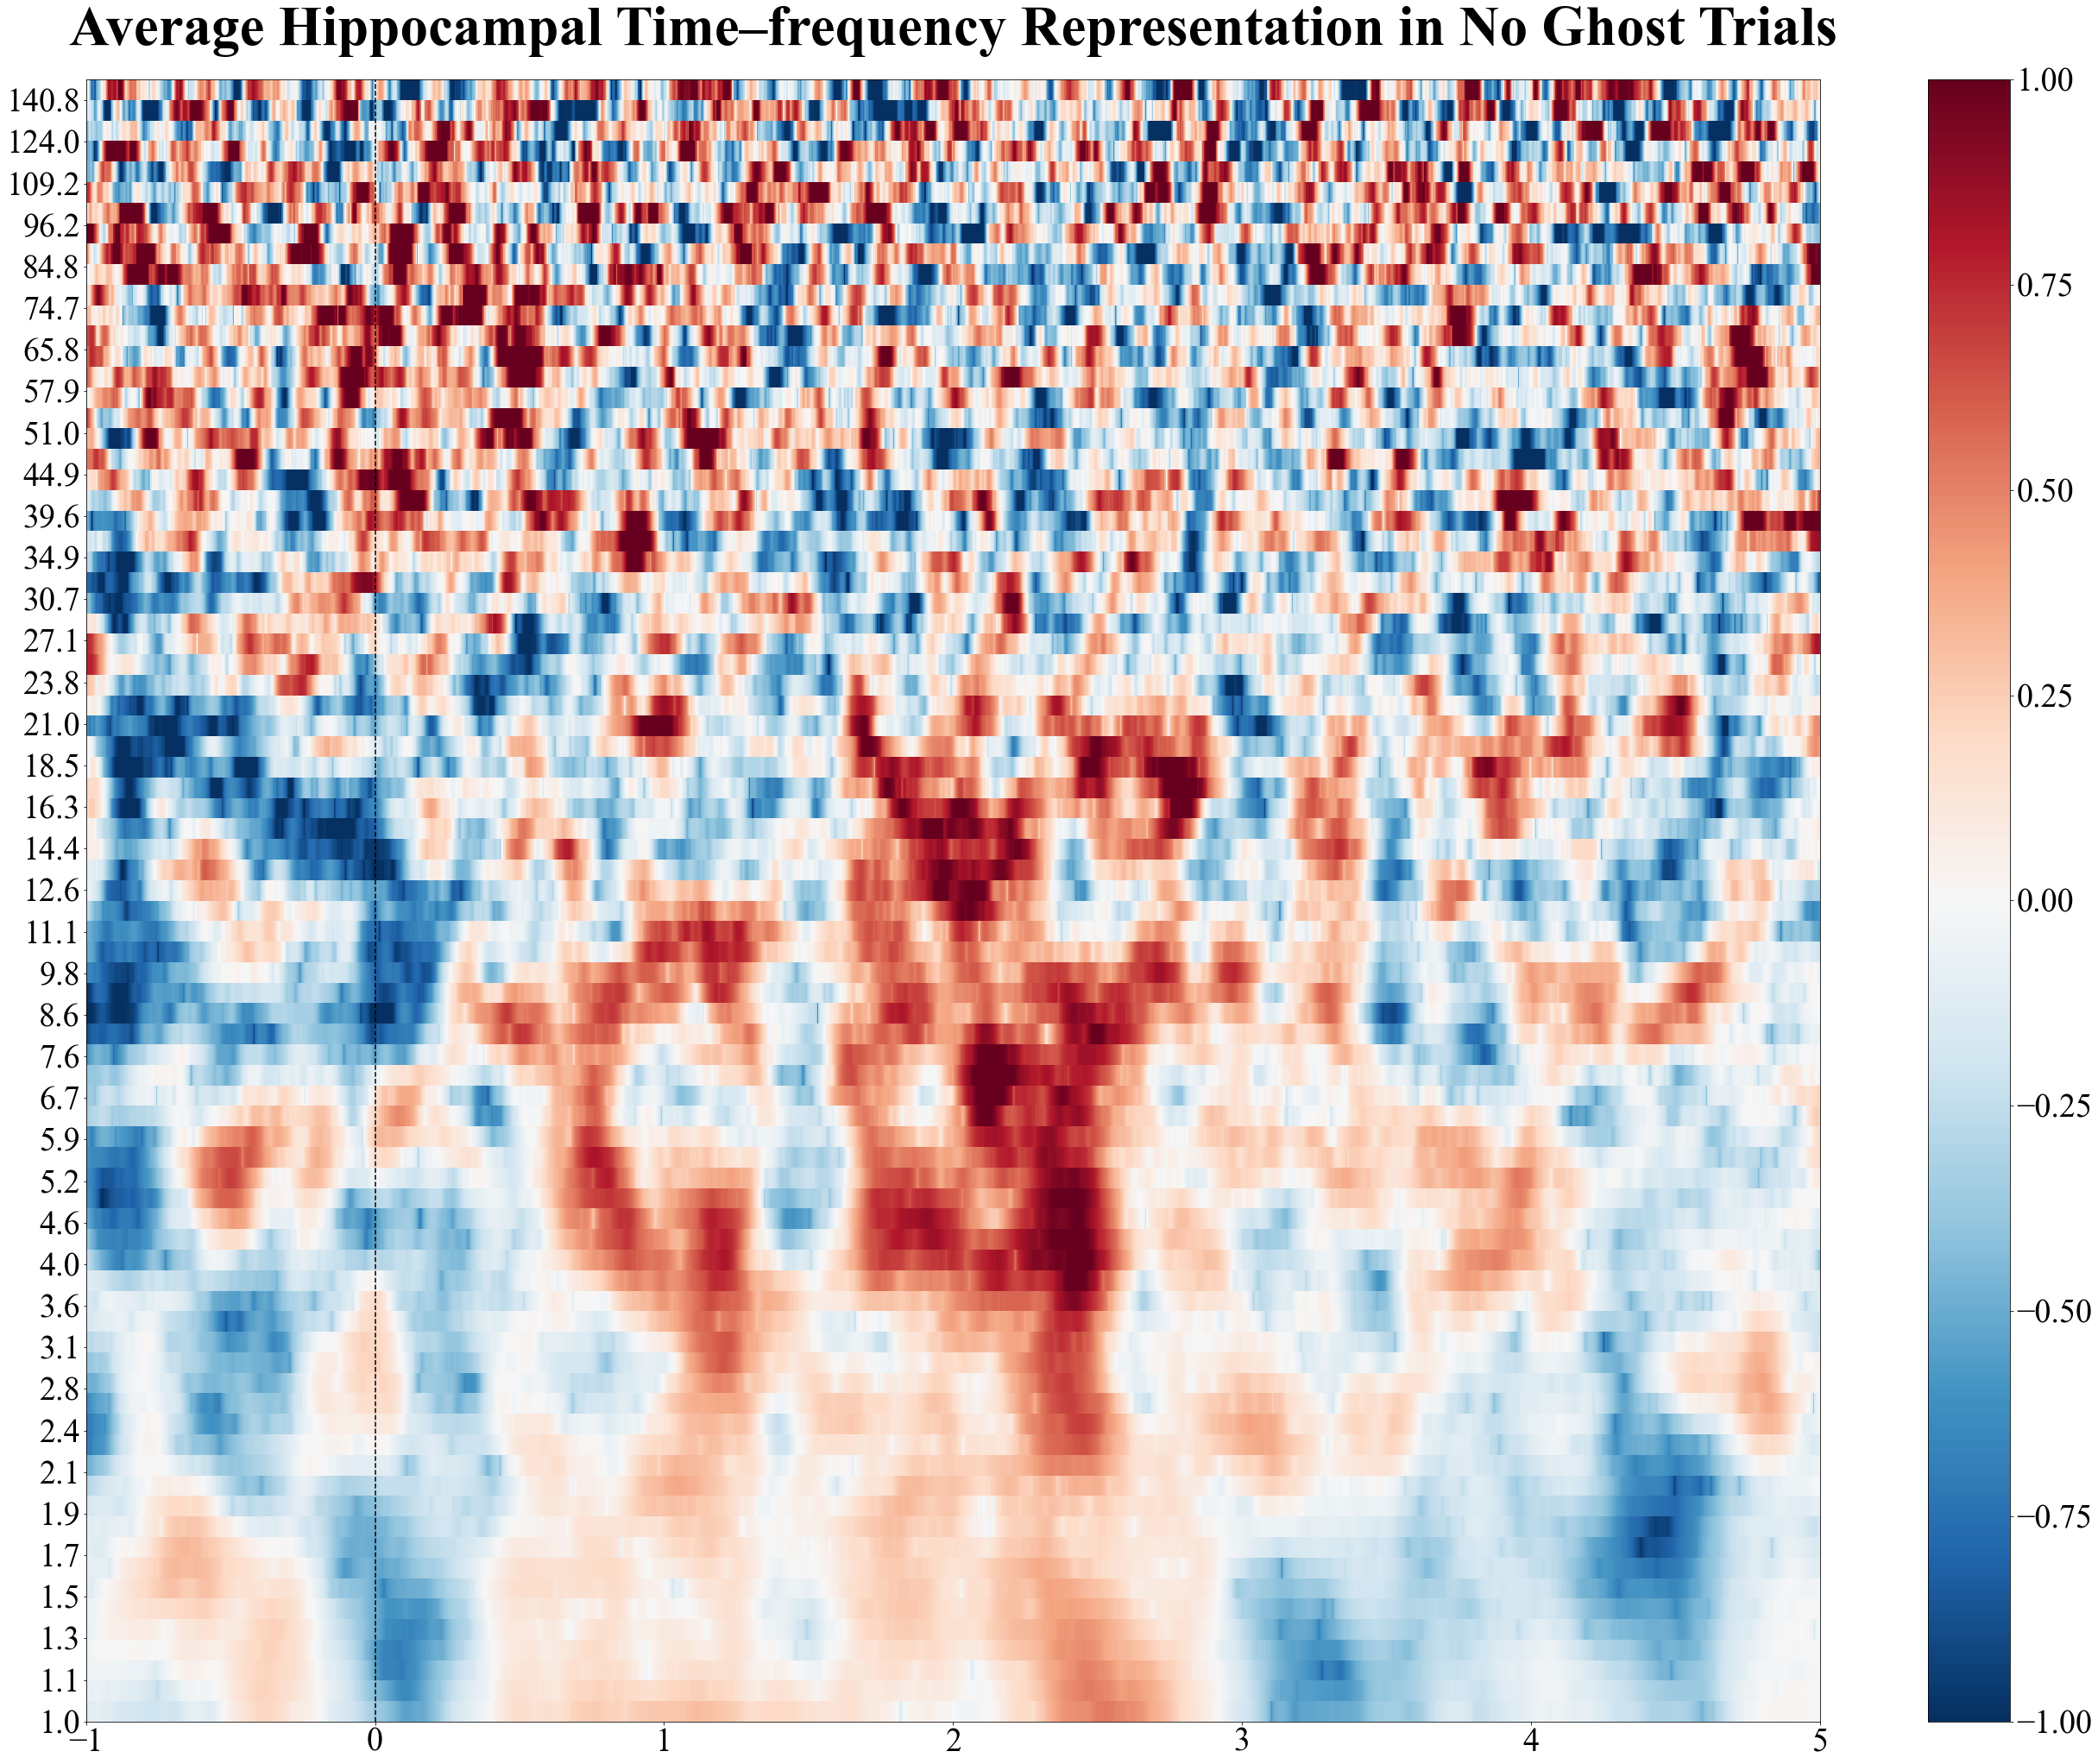

In [5]:
plot_allsub_averages(all_subs_average_hc_noghost, "Average Hippocampal Time–frequency Representation in No Ghost Trials", 'average_hc_noghosttrialonset_all_subs.png')


## OFC

In [6]:
sub_list = ['SLCH002', 'BJH016', 'BJH025', 'BJH021', 'LL10', 'LL12', 'LL13']

all_subs_average_ofc_ghost = calculate_trial_onset_average(sub_list, 'TrialType <= 16', 'ofc')
all_subs_average_ofc_noghost = calculate_trial_onset_average(sub_list, 'TrialType > 16', 'ofc')
    

Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/trial_onset/ofc-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/BJH016/ieeg/trial_onset/ofc-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/BJH025/ieeg/trial_onset/ofc-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/BJH021/ieeg/trial_onset/ofc-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/LL10/ieeg/trial_onset/ofc-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/LL12/ieeg/trial_onset/ofc-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/LL13/ieeg/trial_onset/ofc-tfr.h5 ...
Adding metadata wi

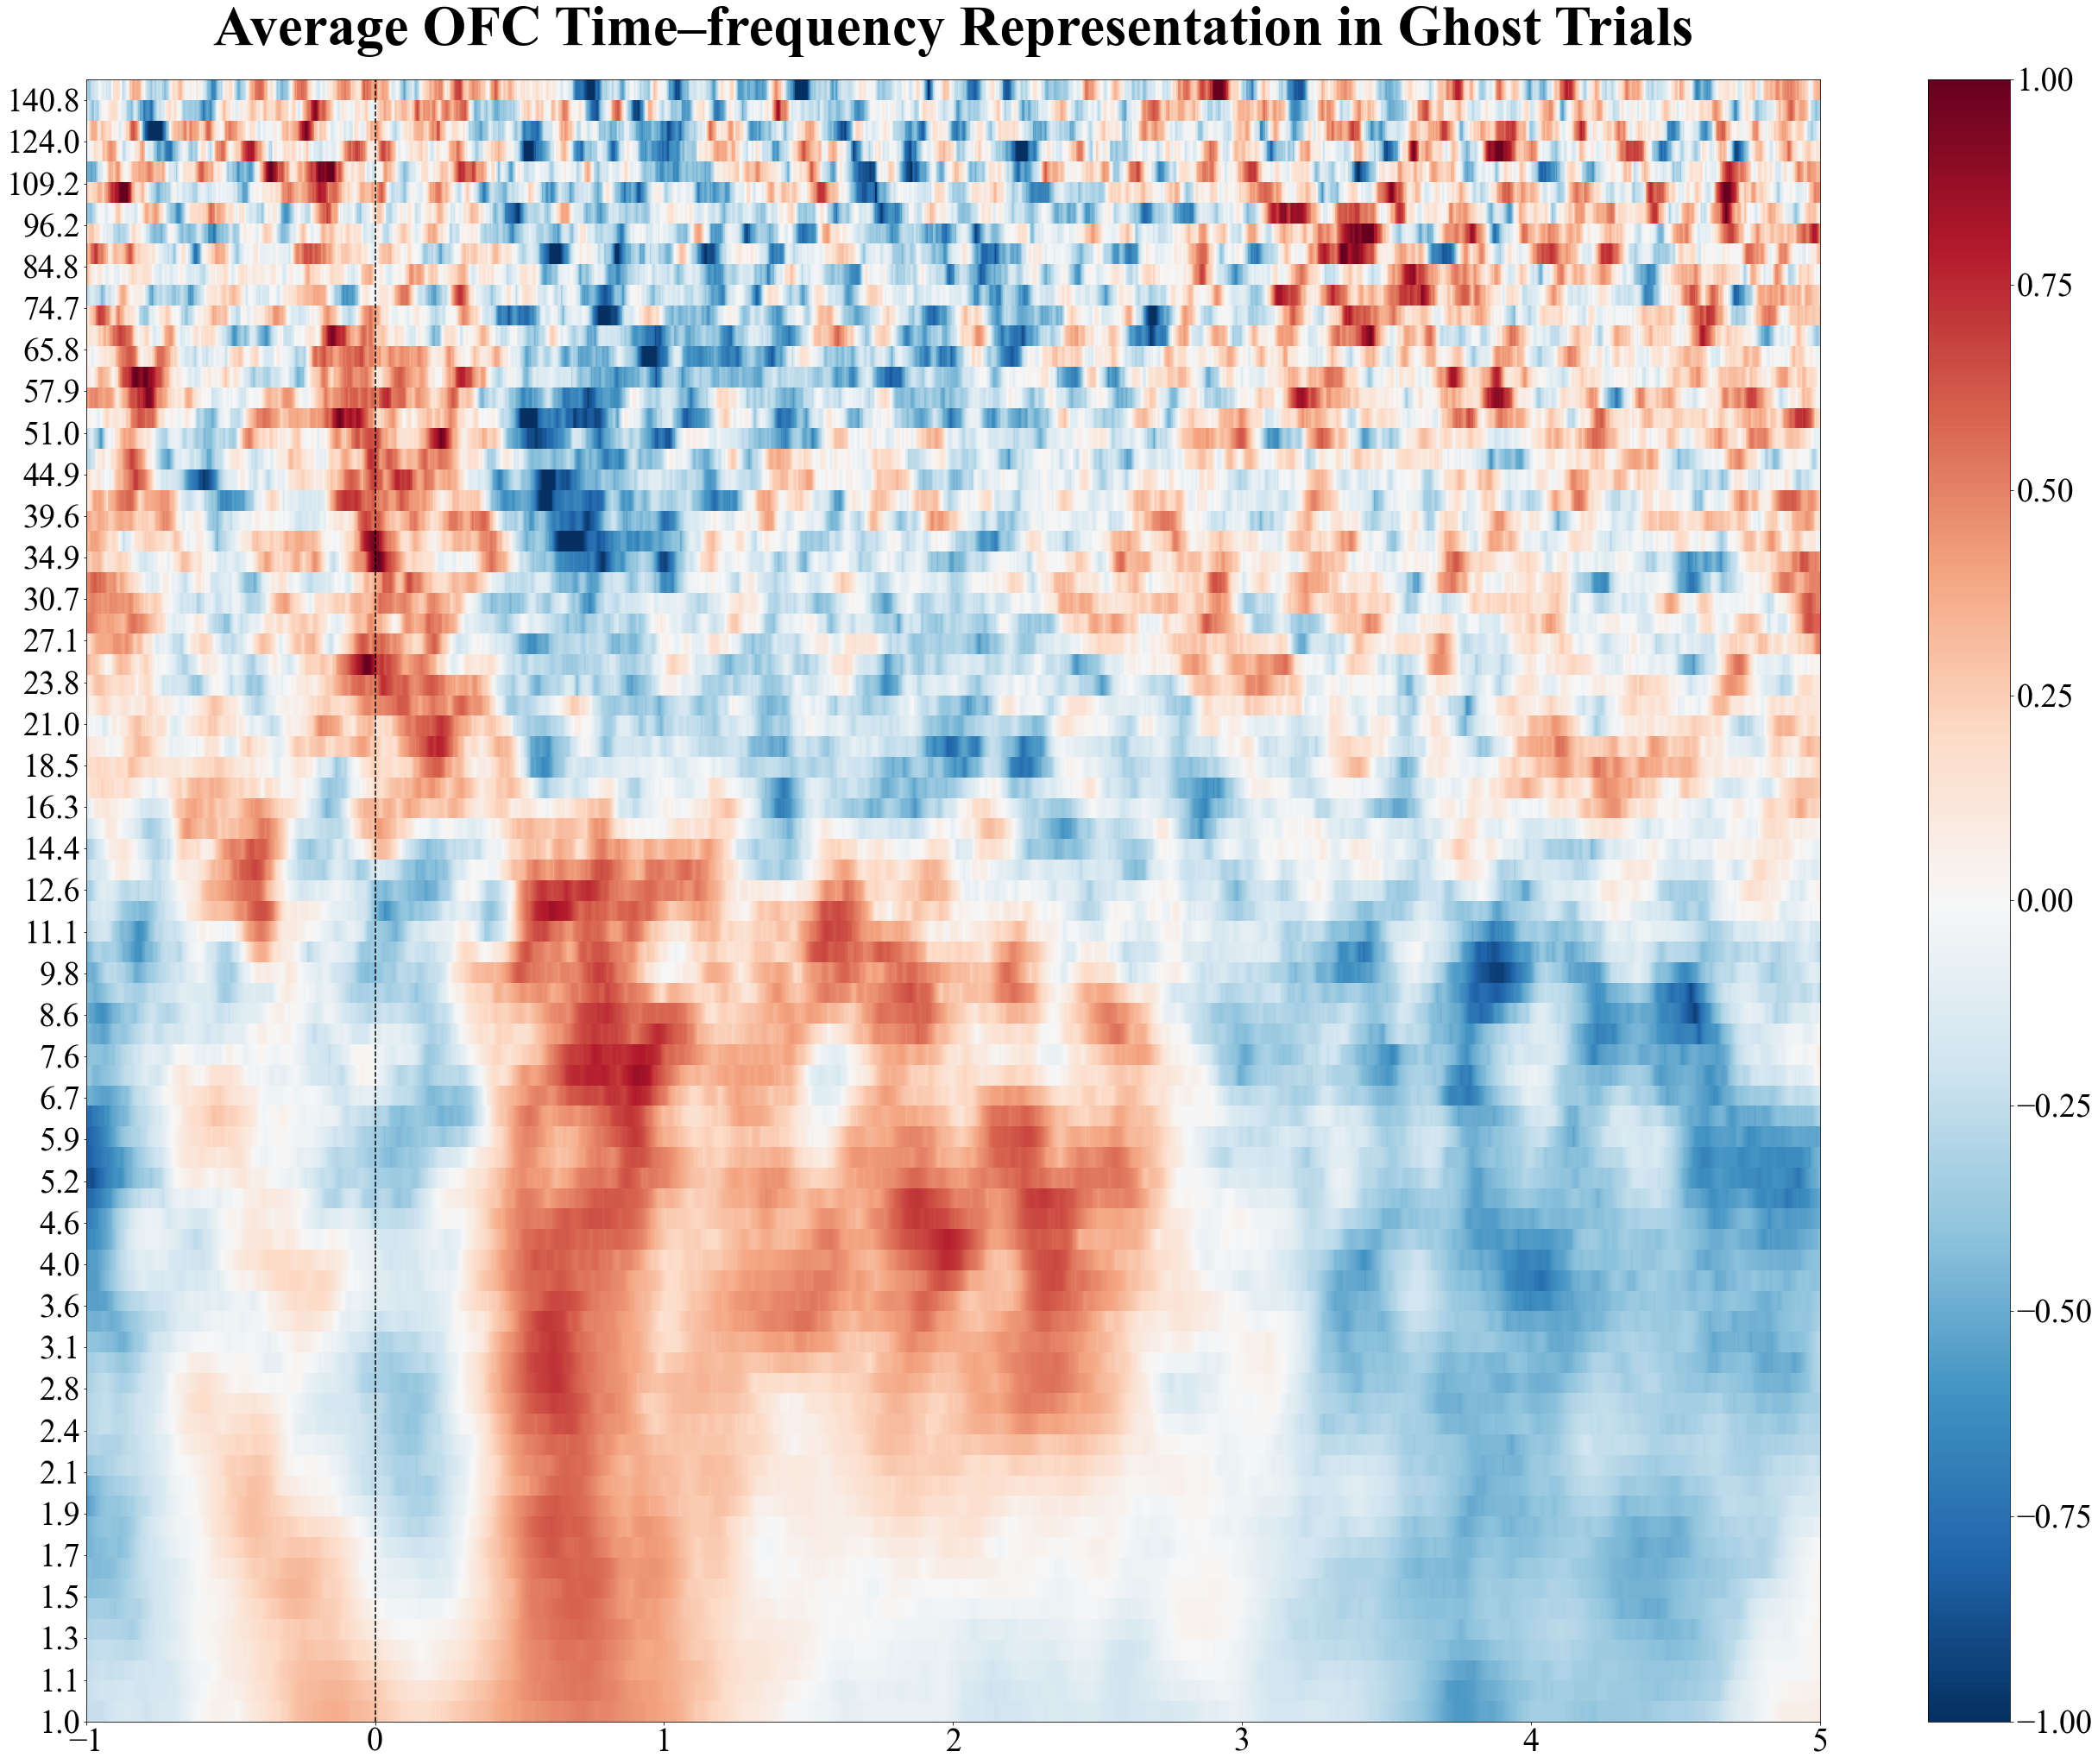

In [7]:
plot_allsub_averages(all_subs_average_ofc_ghost, "Average OFC Time–frequency Representation in Ghost Trials", 'average_ofc_ghosttrialonset_all_subs.png')


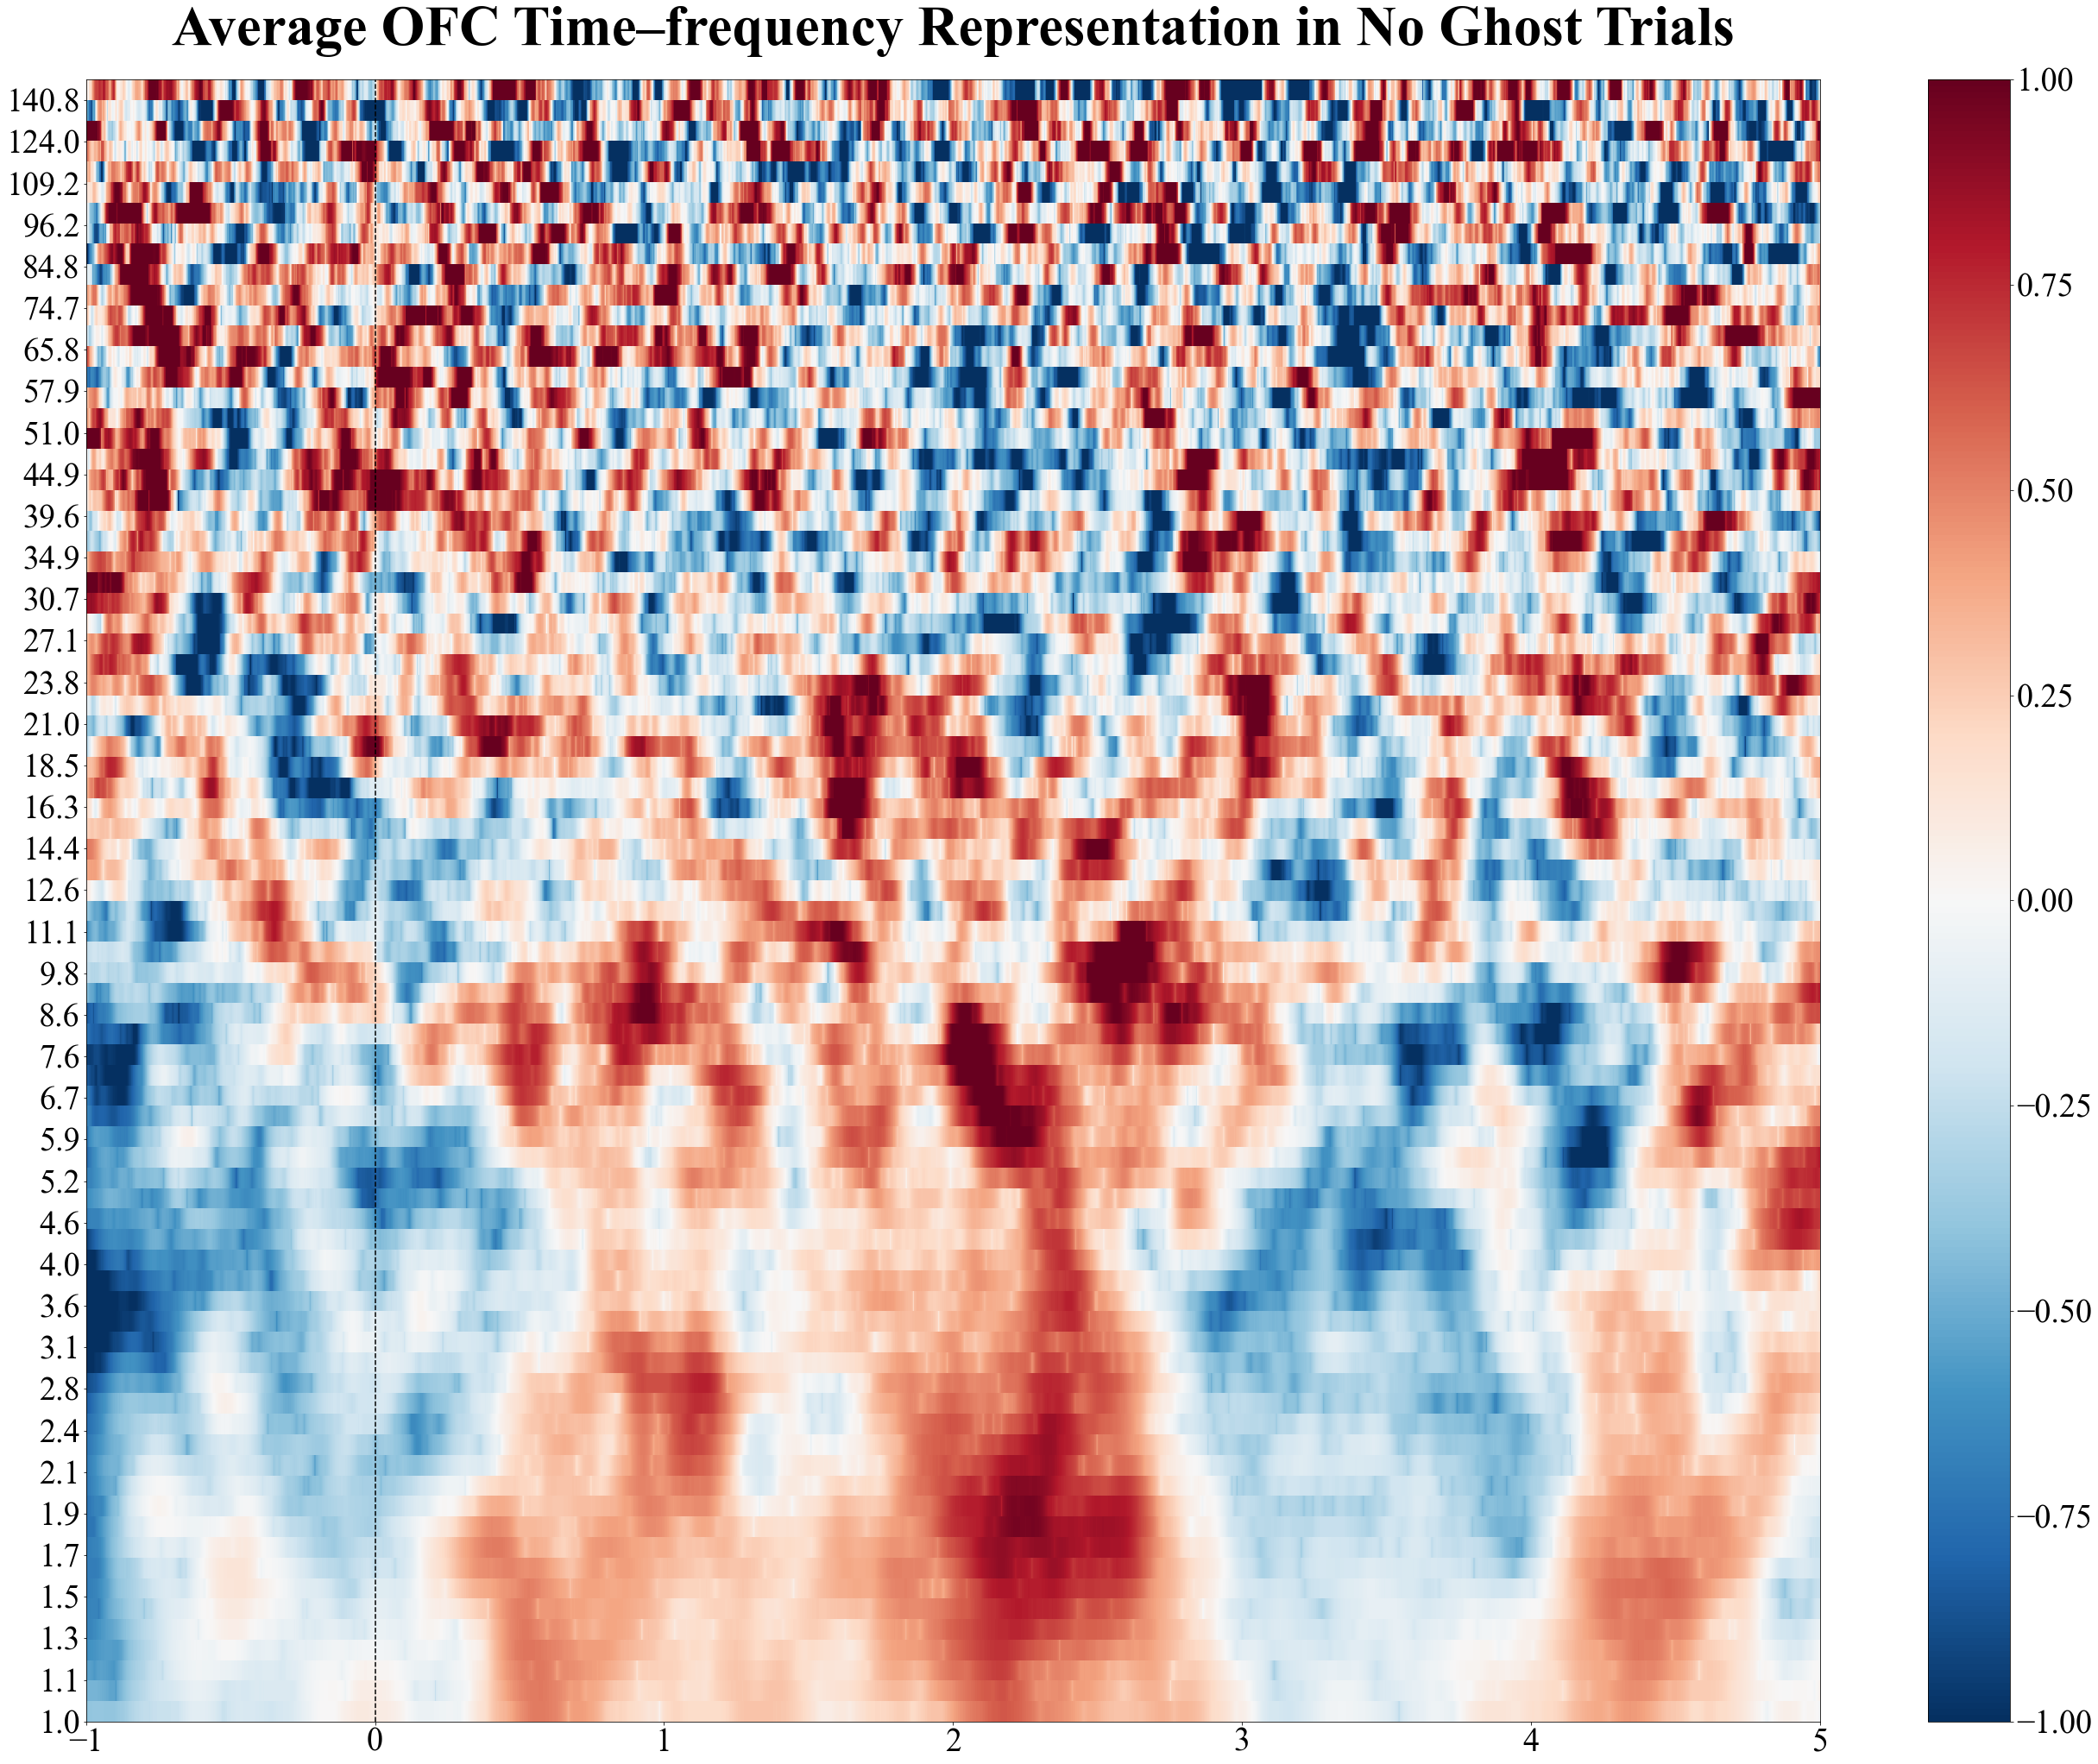

In [8]:
plot_allsub_averages(all_subs_average_ofc_noghost, "Average OFC Time–frequency Representation in No Ghost Trials", 'average_ofc_noghosttrialonset_all_subs.png')

## Anterior Cingulate

In [9]:
sub_list = ['SLCH002', 'BJH016', 'BJH025', 'BJH021', 'LL10', 'LL12', 'LL13']

all_subs_average_cing_ghost = calculate_trial_onset_average(sub_list, 'TrialType <= 16', 'cing')
all_subs_average_cing_noghost = calculate_trial_onset_average(sub_list, 'TrialType > 16', 'cing')


Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/trial_onset/cing-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/BJH016/ieeg/trial_onset/cing-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/BJH025/ieeg/trial_onset/cing-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/BJH021/ieeg/trial_onset/cing-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/LL10/ieeg/trial_onset/cing-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/LL12/ieeg/trial_onset/cing-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/LL13/ieeg/trial_onset/cing-tfr.h5 ...
Adding meta

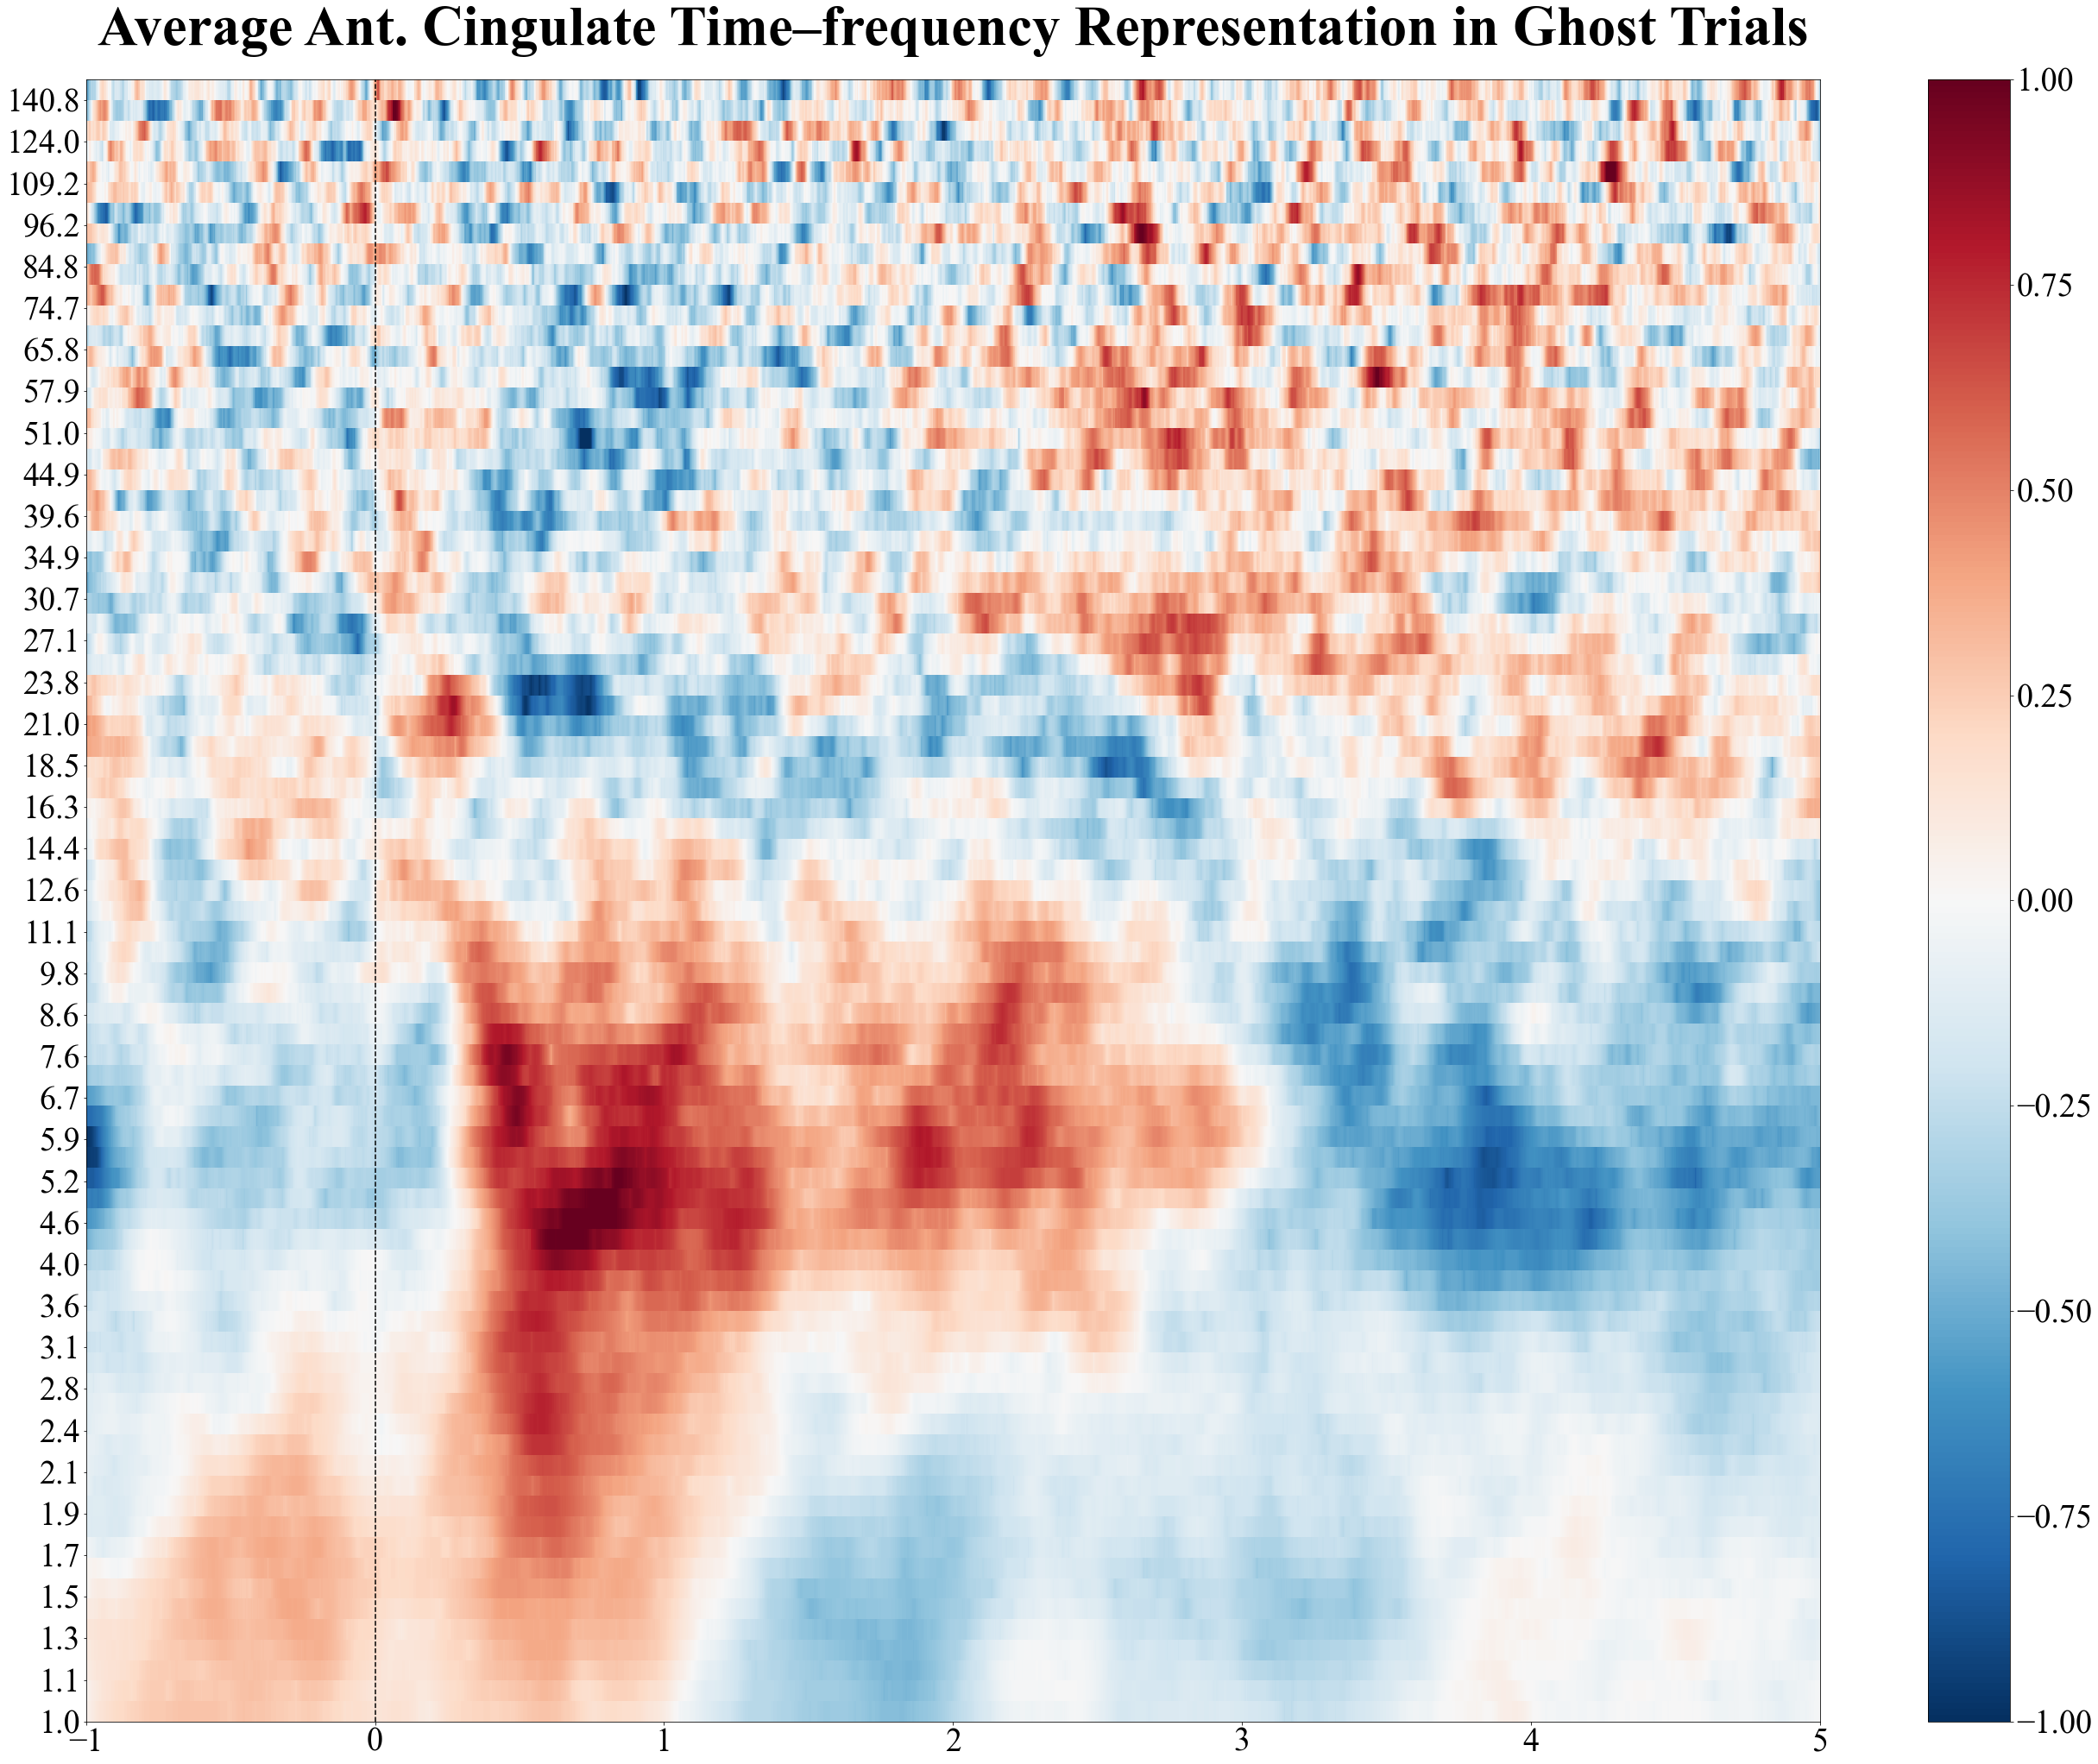

In [10]:
plot_allsub_averages(all_subs_average_cing_ghost, "Average Ant. Cingulate Time–frequency Representation in Ghost Trials", 'average_cing_ghosttrialonset_all_subs.png')



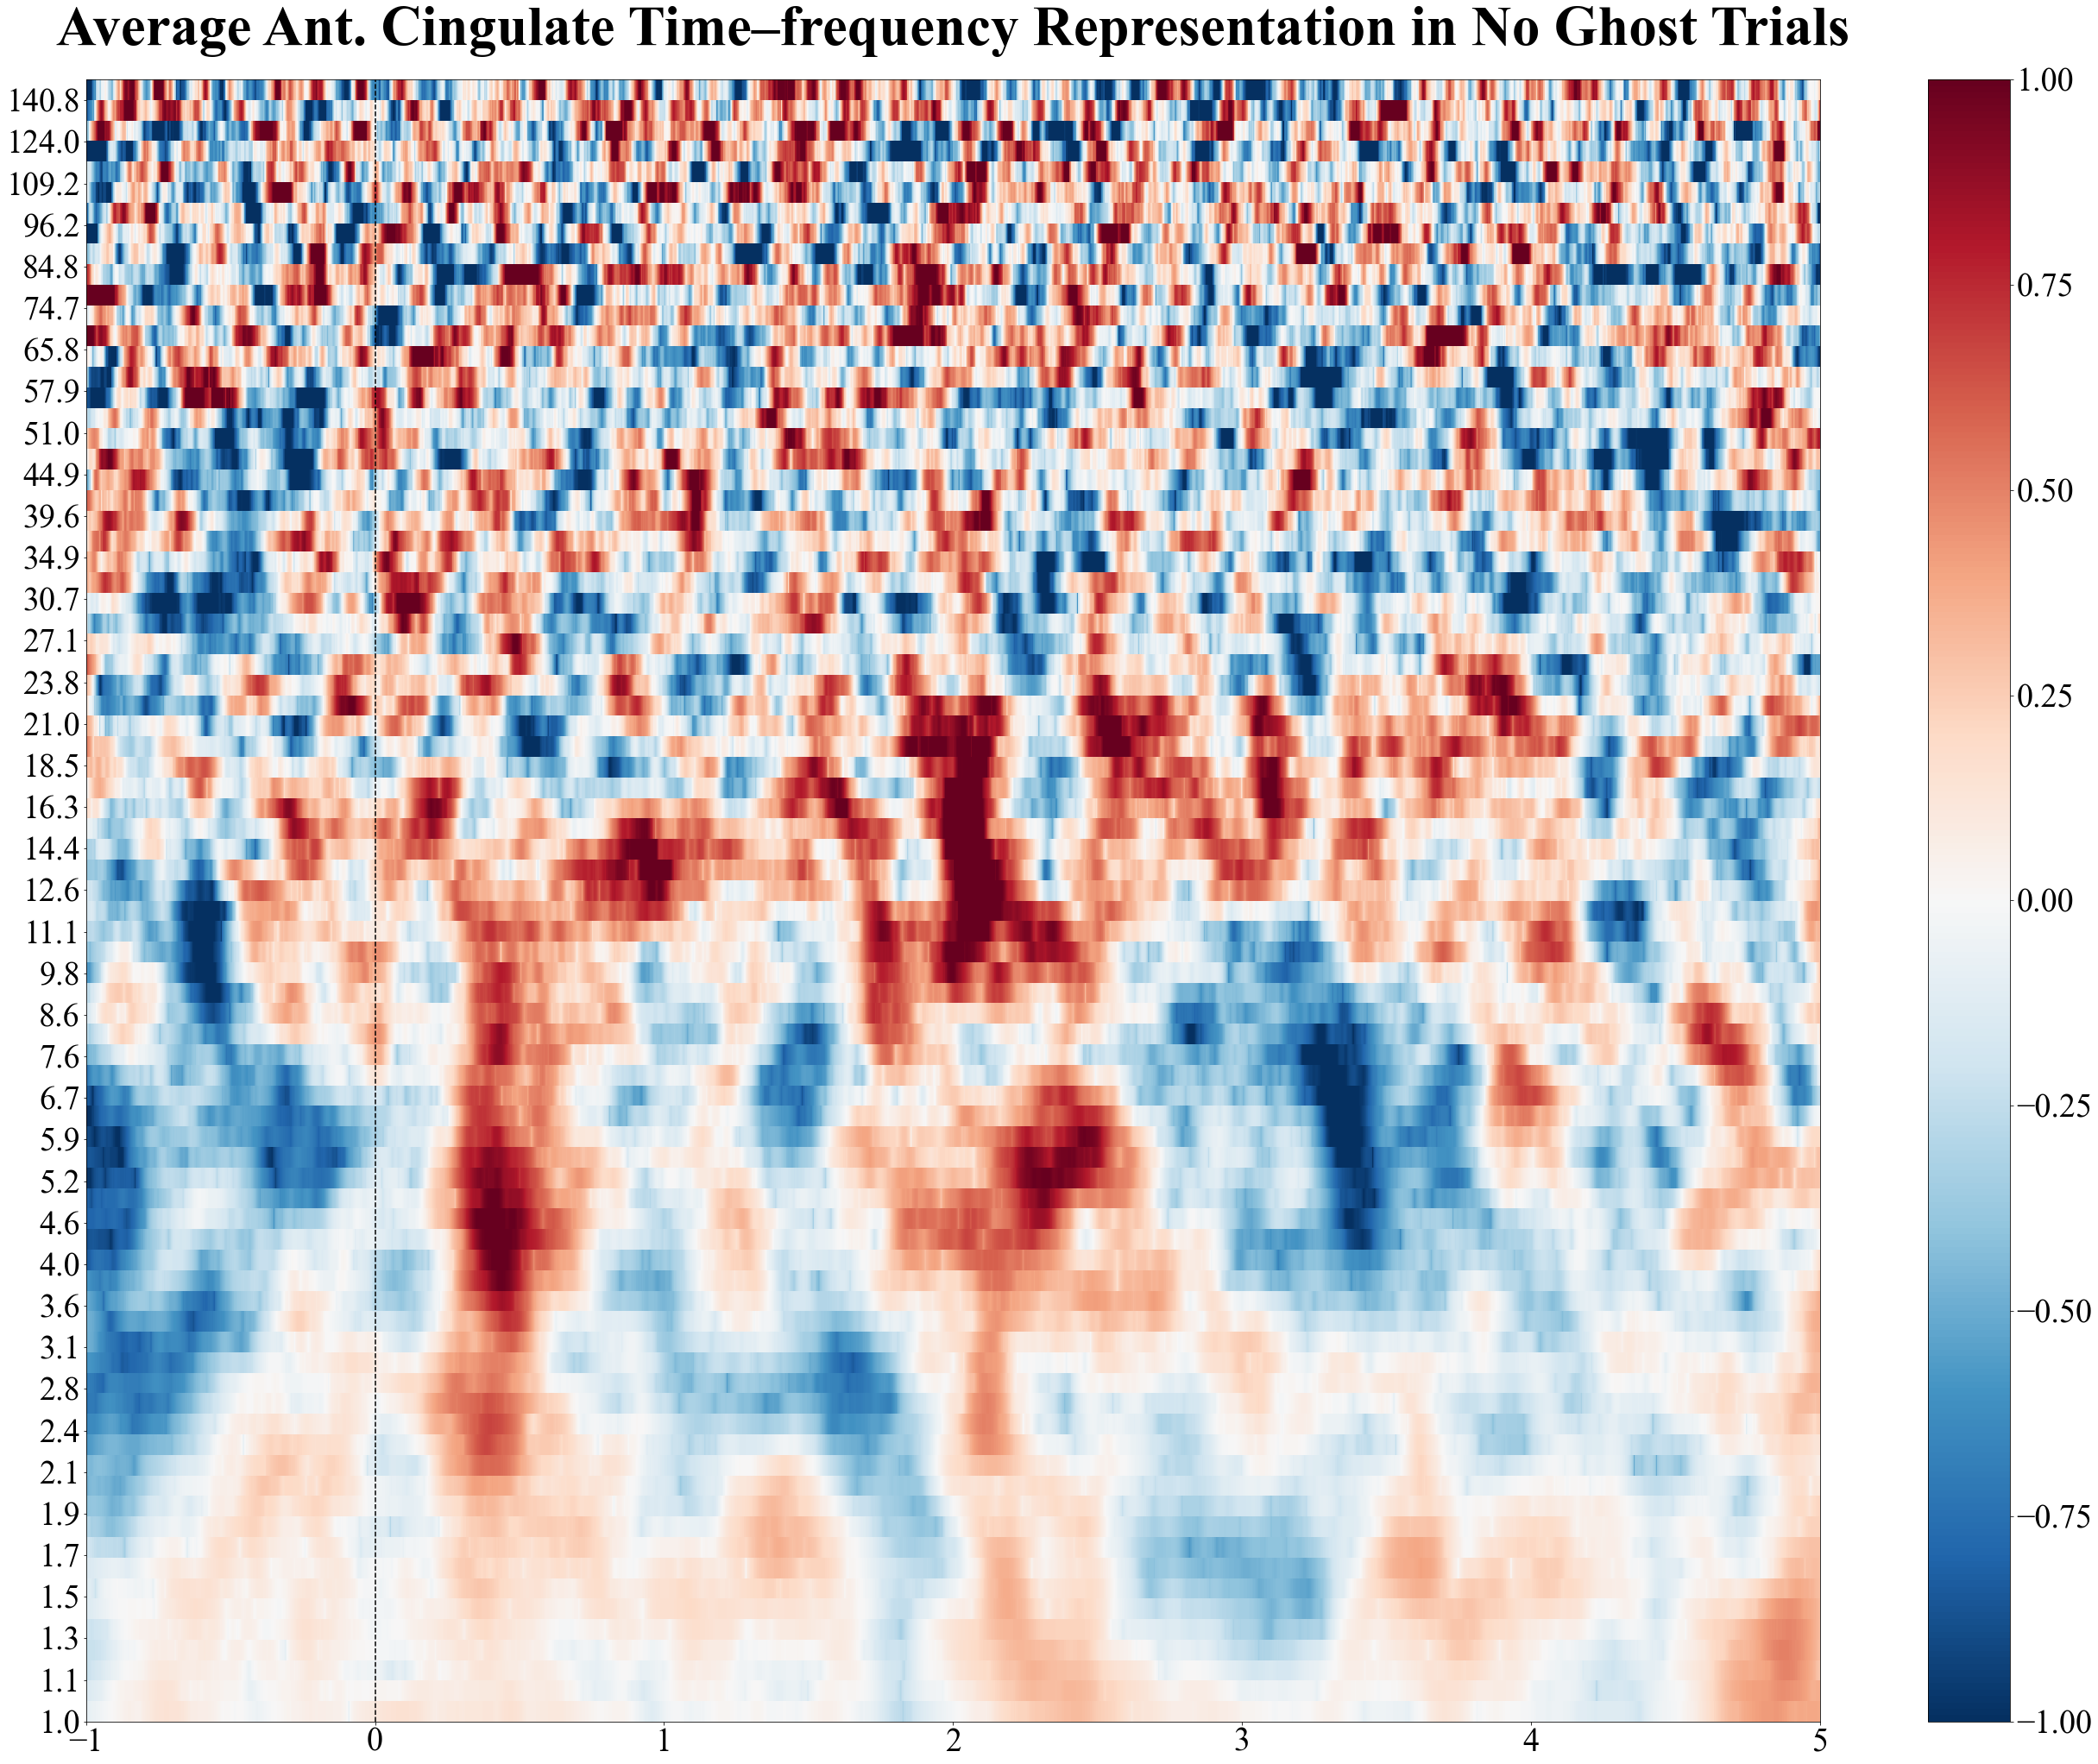

In [11]:
plot_allsub_averages(all_subs_average_cing_noghost, "Average Ant. Cingulate Time–frequency Representation in No Ghost Trials", 'average_cing_noghosttrialonset_all_subs.png')



## Amygdala

In [12]:
sub_list = ['SLCH002', 'BJH016', 'BJH021',  'LL10', 'LL12', 'LL13']

all_subs_average_amyg_ghost = calculate_trial_onset_average(sub_list, 'TrialType <= 16', 'amyg')
all_subs_average_amyg_noghost = calculate_trial_onset_average(sub_list, 'TrialType > 16', 'amyg')


Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/trial_onset/amyg-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/BJH016/ieeg/trial_onset/amyg-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/BJH021/ieeg/trial_onset/amyg-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/LL10/ieeg/trial_onset/amyg-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/LL12/ieeg/trial_onset/amyg-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/LL13/ieeg/trial_onset/amyg-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/trial_onset/amyg-tfr.h5 ...
Adding met

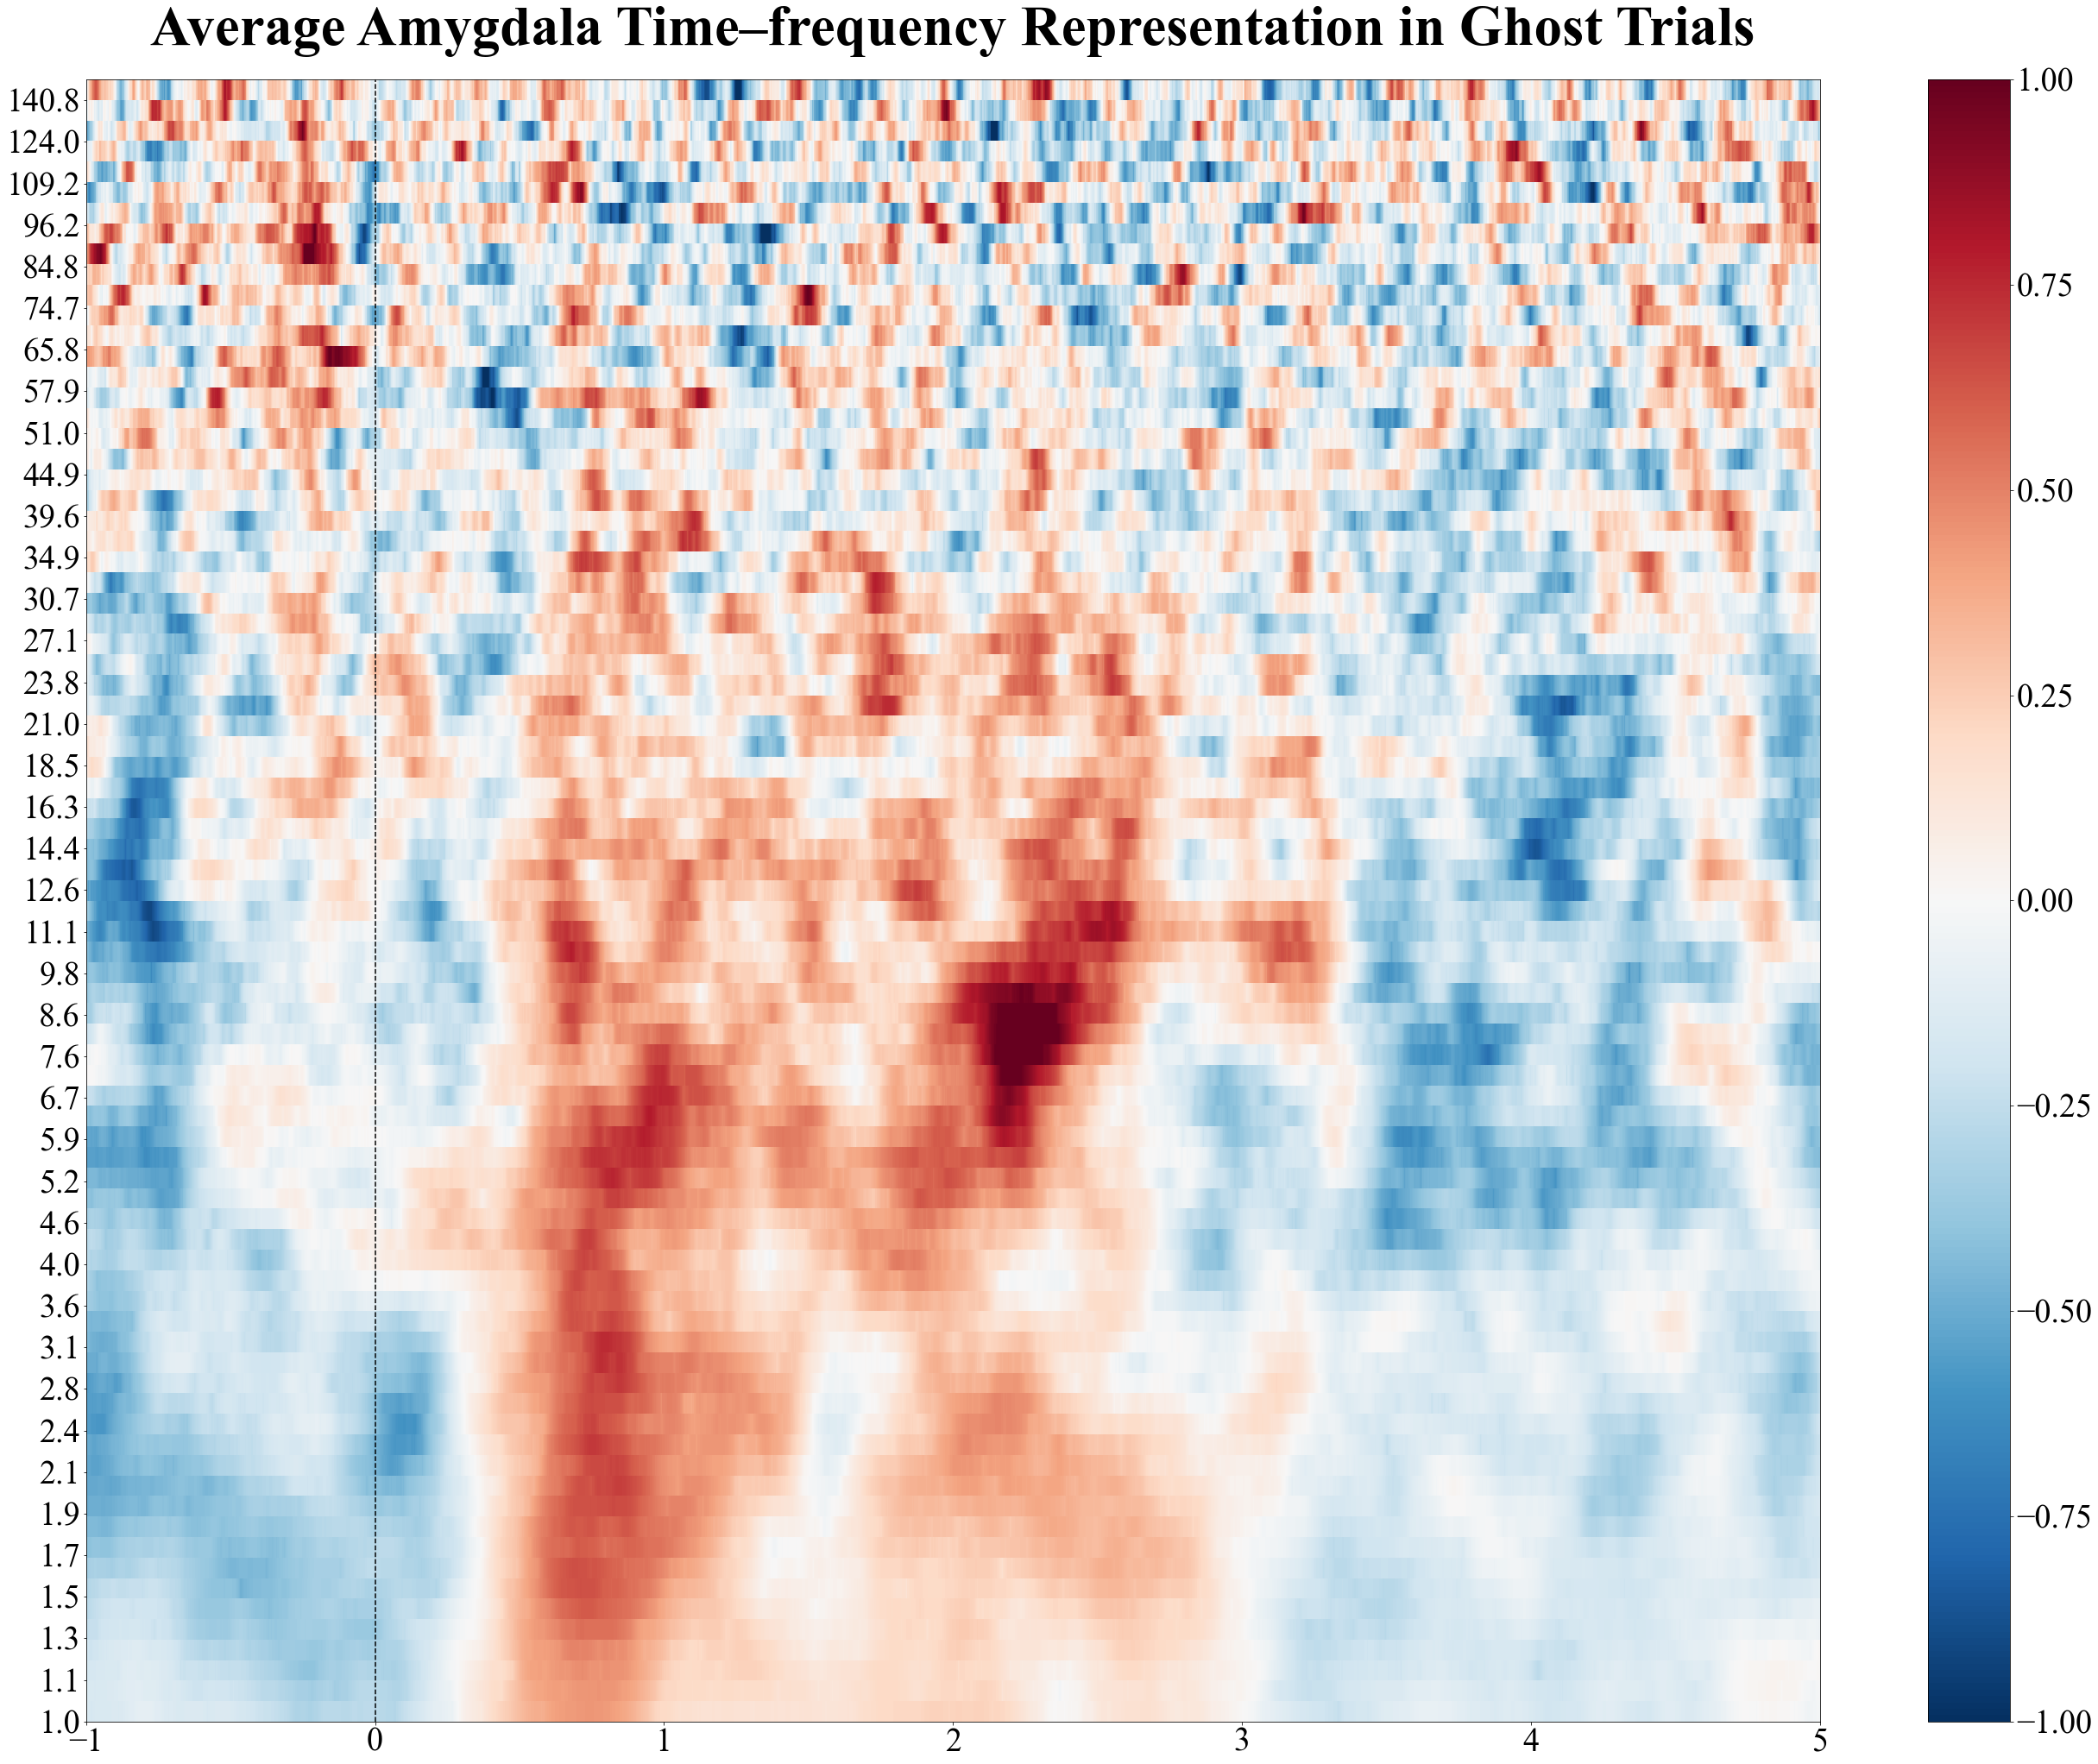

In [13]:
plot_allsub_averages(all_subs_average_amyg_ghost, "Average Amygdala Time–frequency Representation in Ghost Trials", 'average_amyg_ghosttrialonset_all_subs.png')

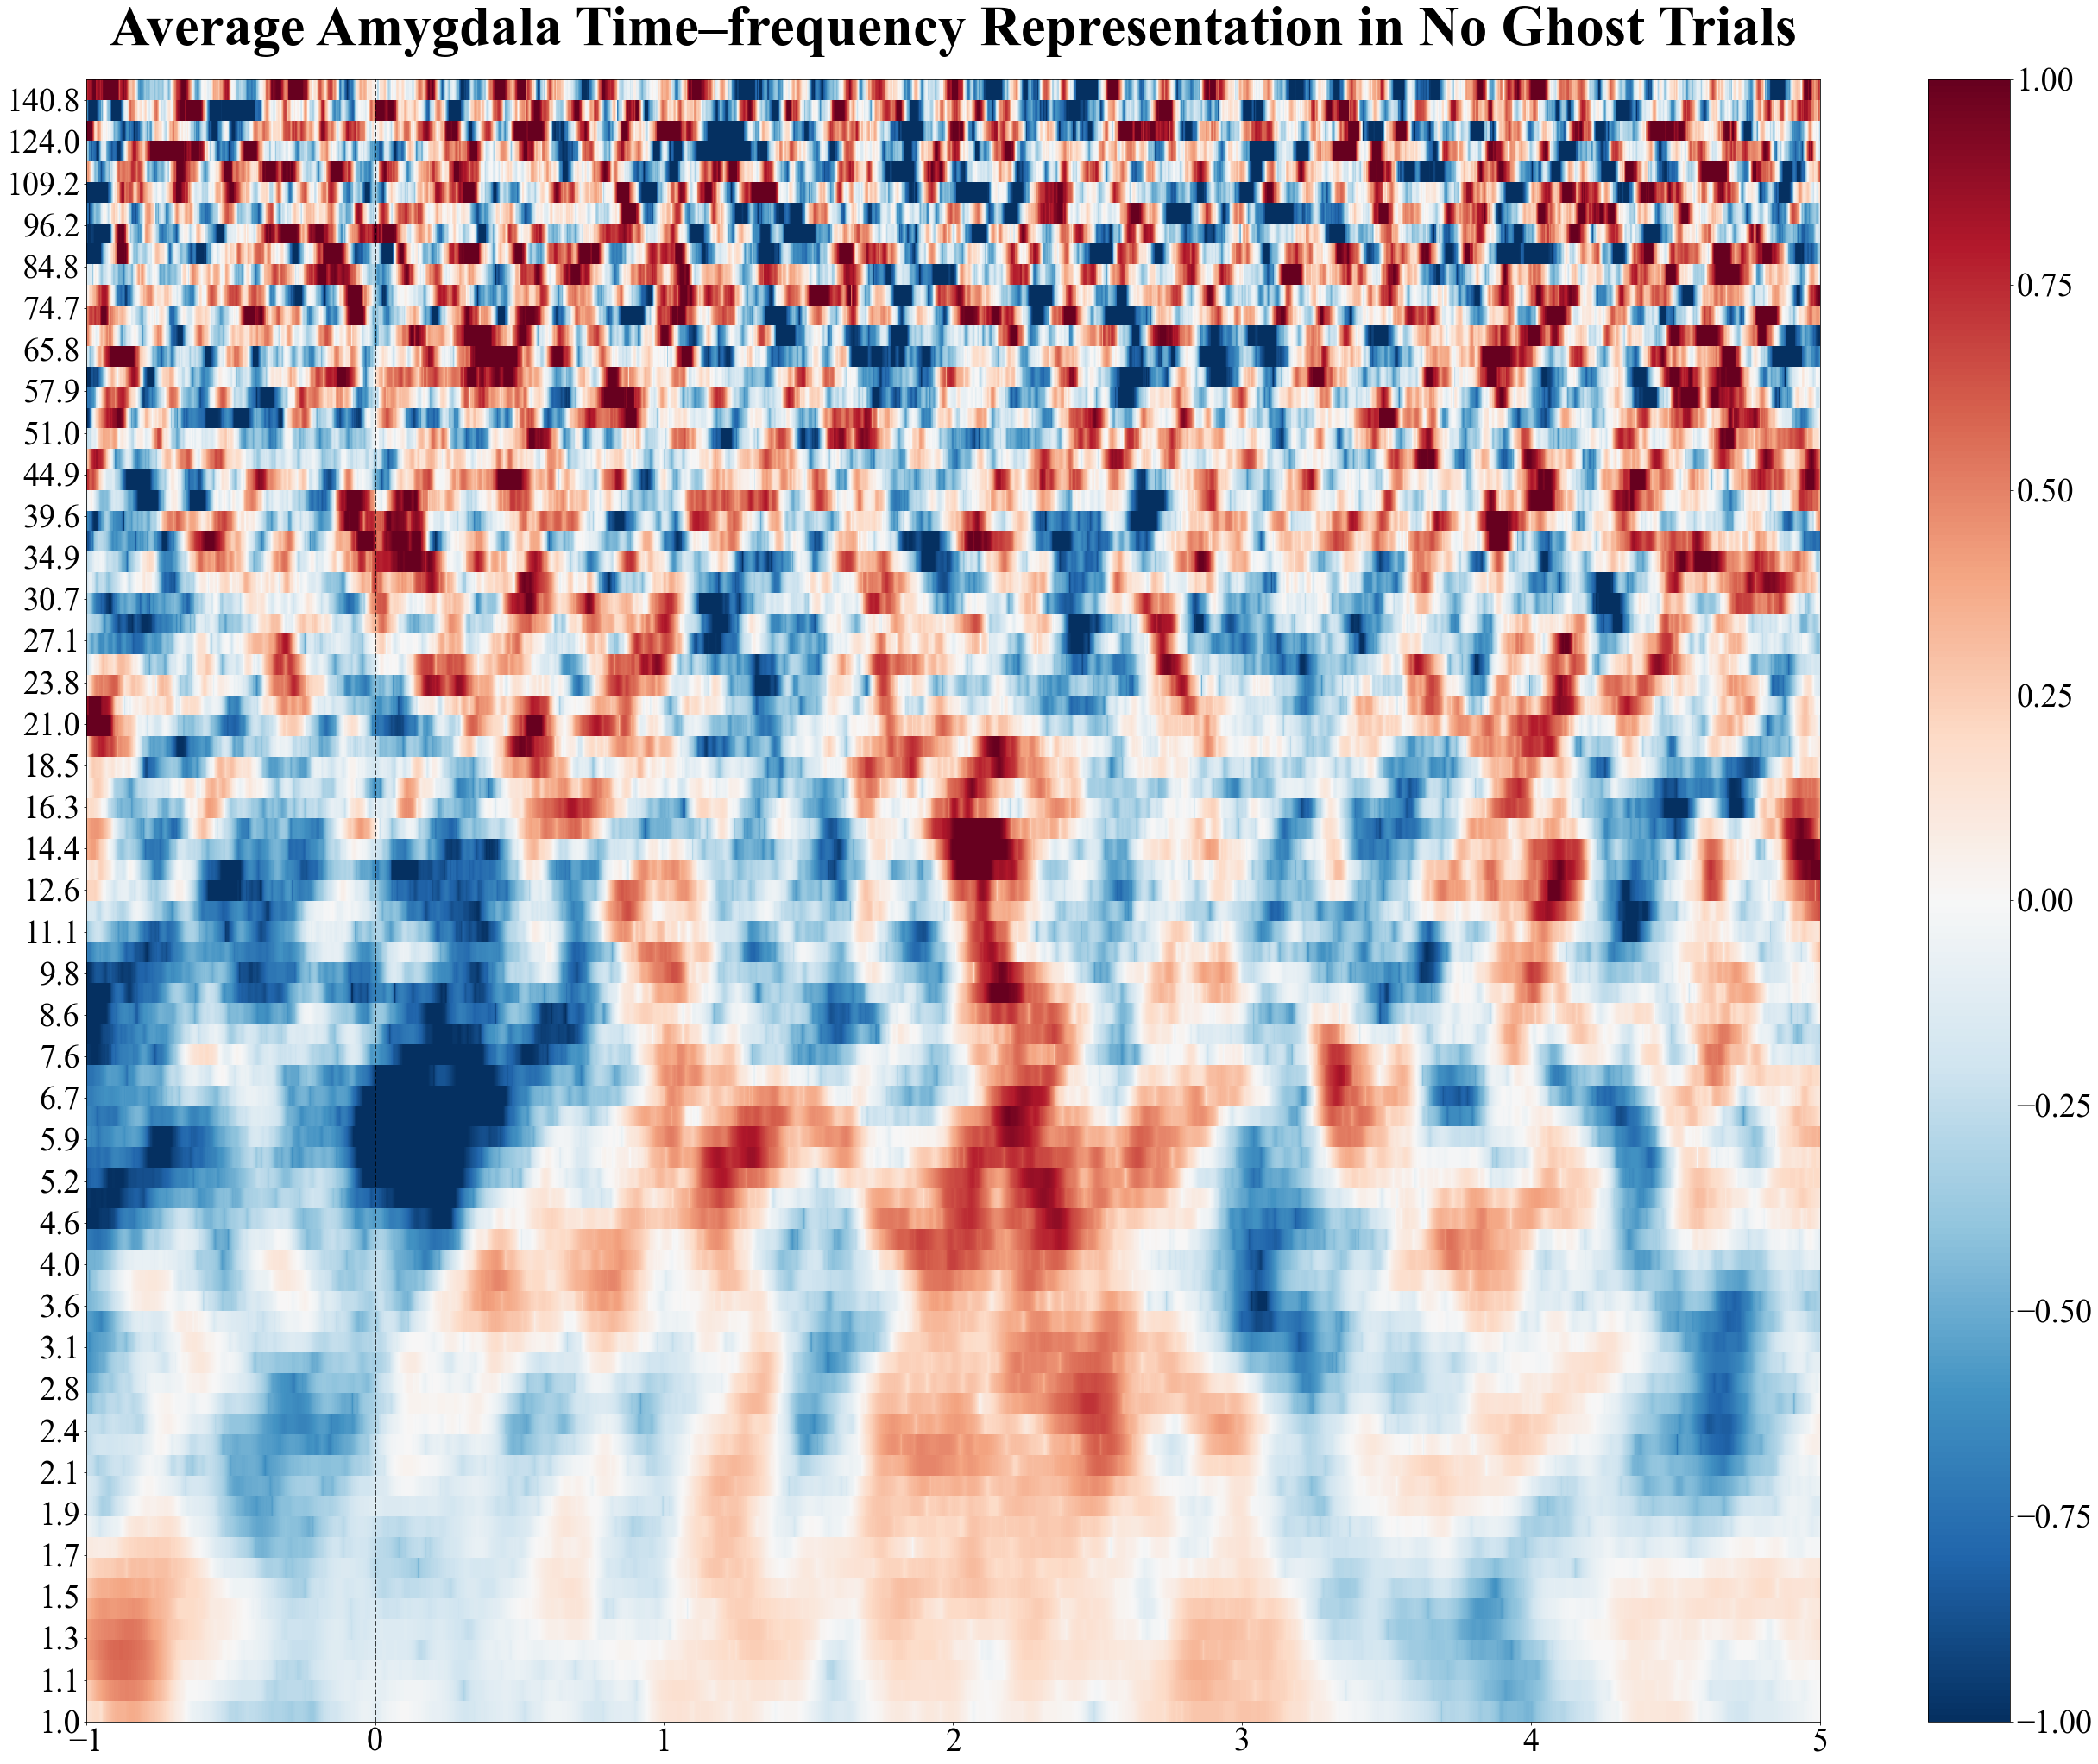

In [14]:
plot_allsub_averages(all_subs_average_amyg_noghost, "Average Amygdala Time–frequency Representation in No Ghost Trials", 'average_amyg_noghosttrialonset_all_subs.png')

# Other Regions

## dlPFC

In [15]:
sub_list = ['SLCH002', 'BJH016', 'BJH025', 'BJH021', 'LL10', 'LL12', 'LL13']

all_subs_average_dlpfc_ghost = calculate_trial_onset_average(sub_list, 'TrialType <= 16', 'dlpfc')
all_subs_average_dlpfc_noghost = calculate_trial_onset_average(sub_list, 'TrialType > 16', 'dlpfc')


Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/trial_onset/dlpfc-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/BJH016/ieeg/trial_onset/dlpfc-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/BJH025/ieeg/trial_onset/dlpfc-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/BJH021/ieeg/trial_onset/dlpfc-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/LL10/ieeg/trial_onset/dlpfc-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/LL12/ieeg/trial_onset/dlpfc-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/LL13/ieeg/trial_onset/dlpfc-tfr.h5 ...
Addi

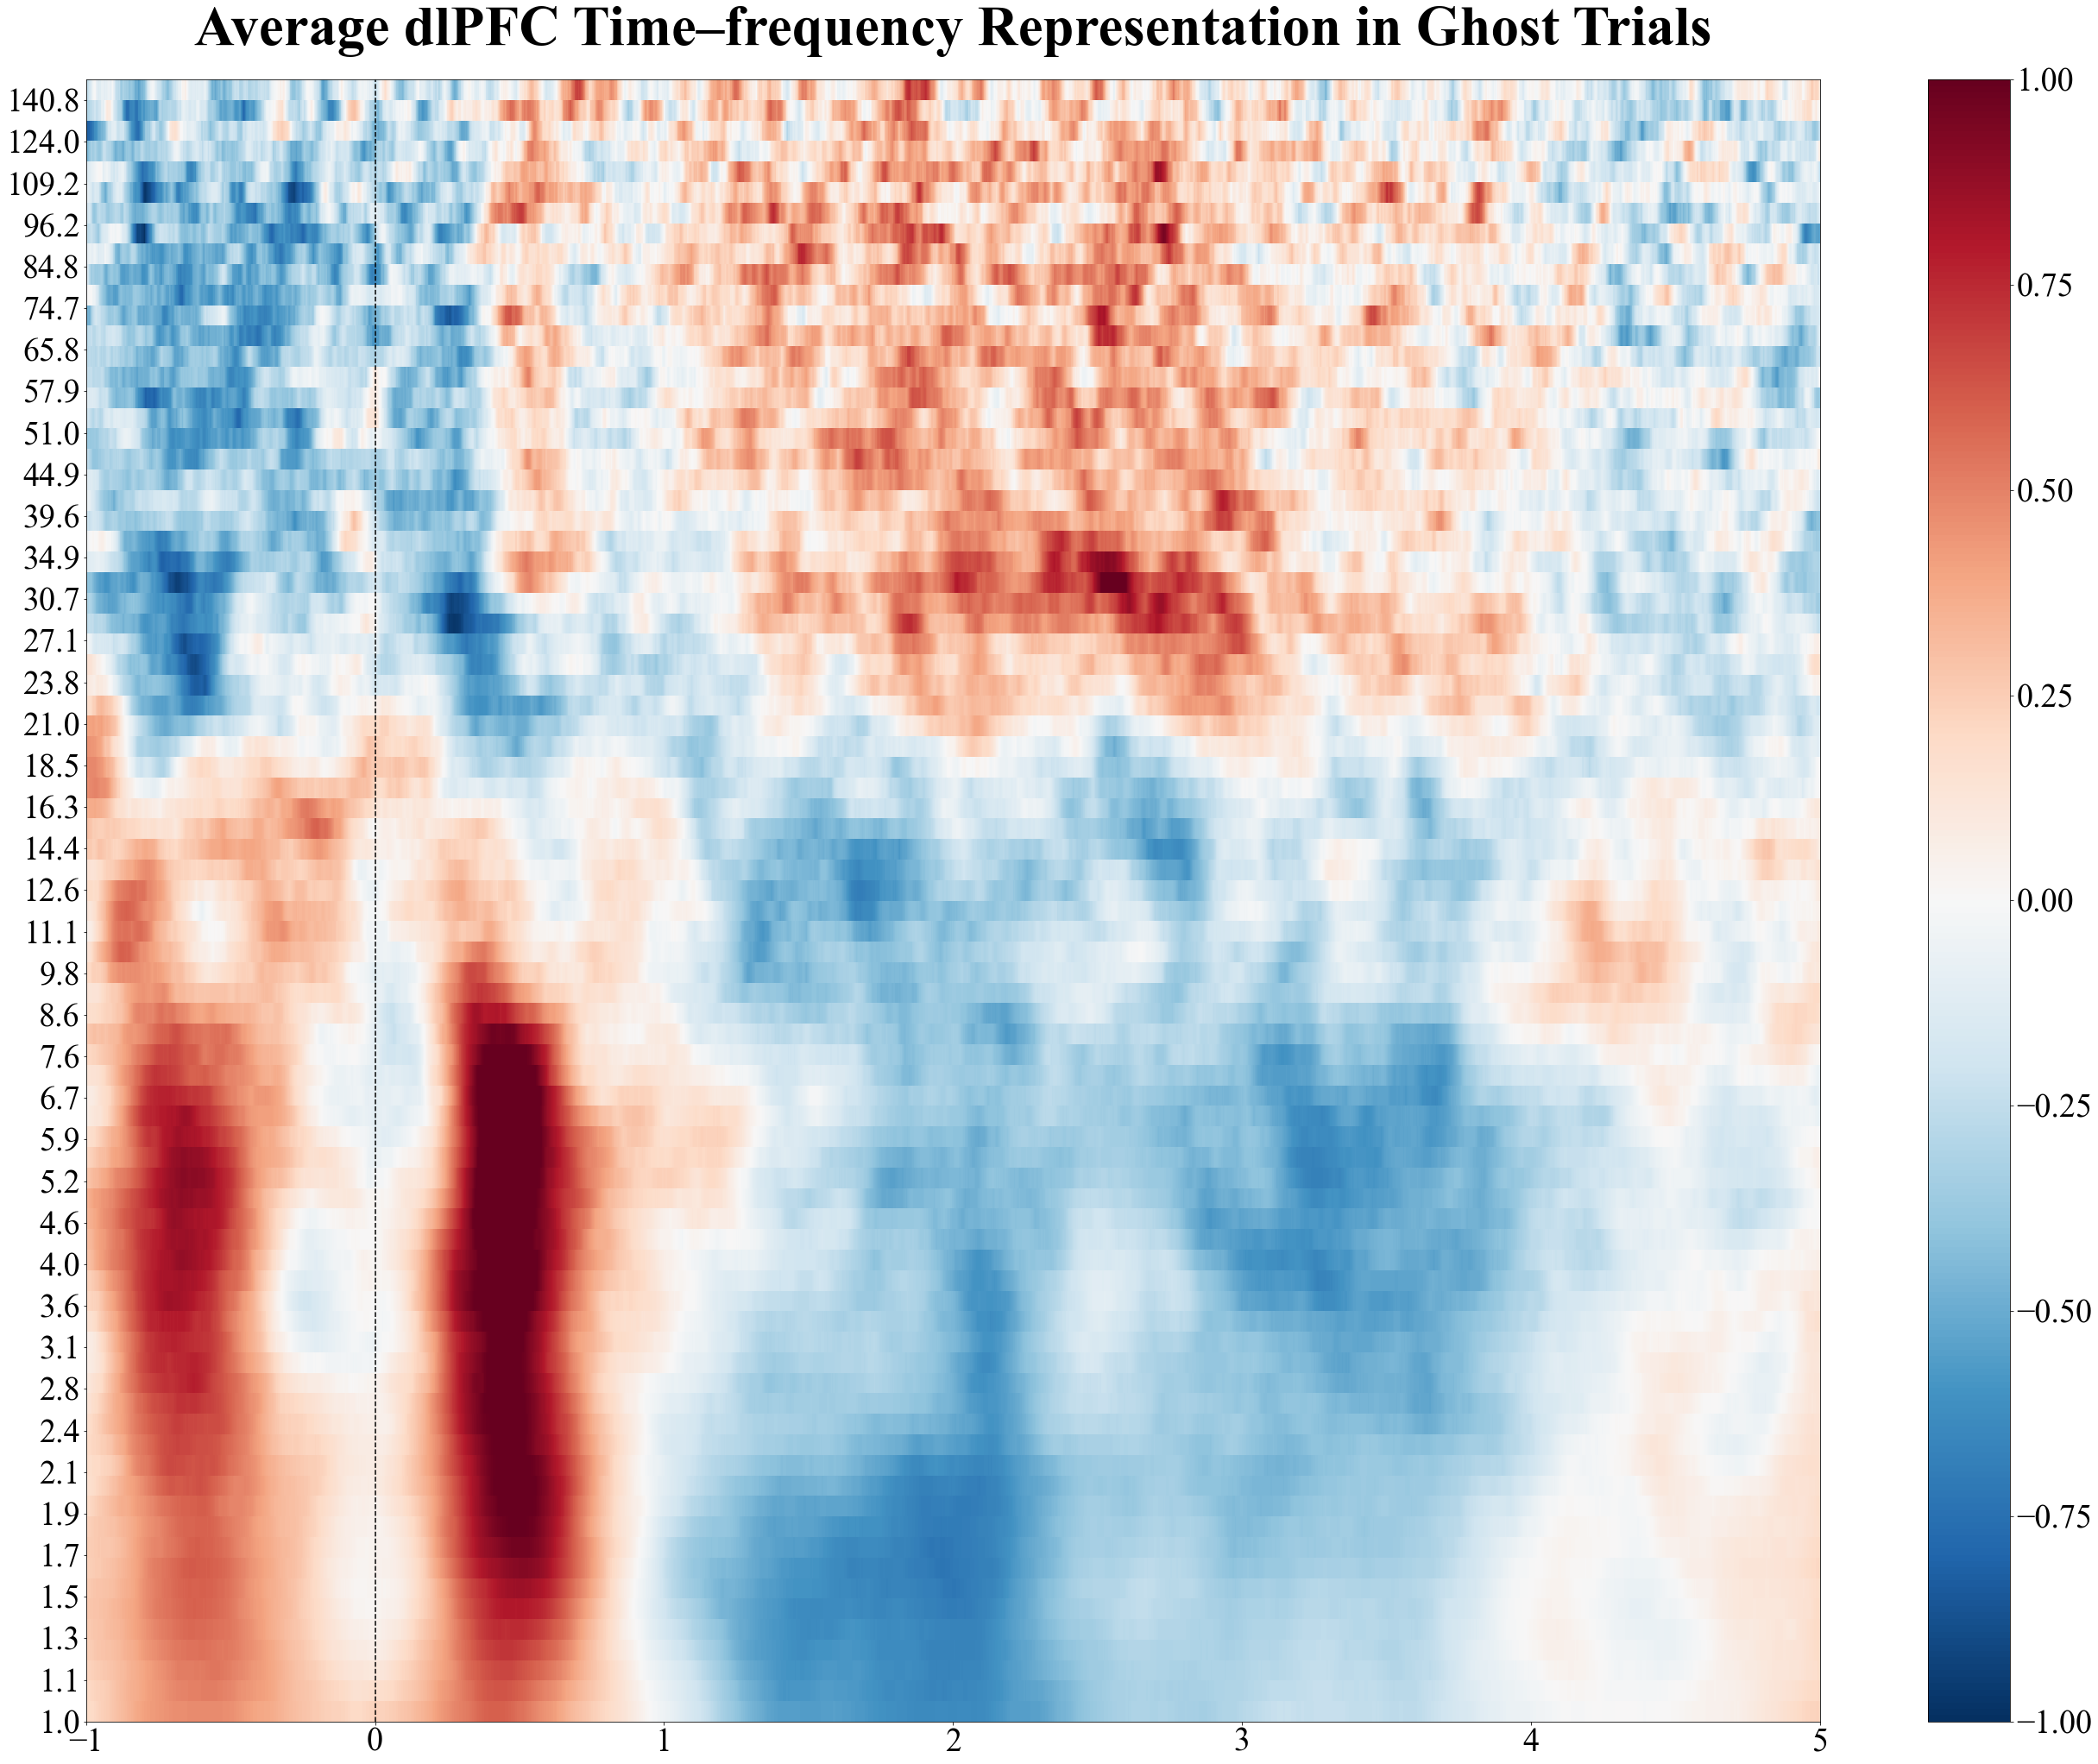

In [16]:
plot_allsub_averages(all_subs_average_dlpfc_ghost, "Average dlPFC Time–frequency Representation in Ghost Trials", 'average_dlpfc_ghosttrialonset_all_subs.png')

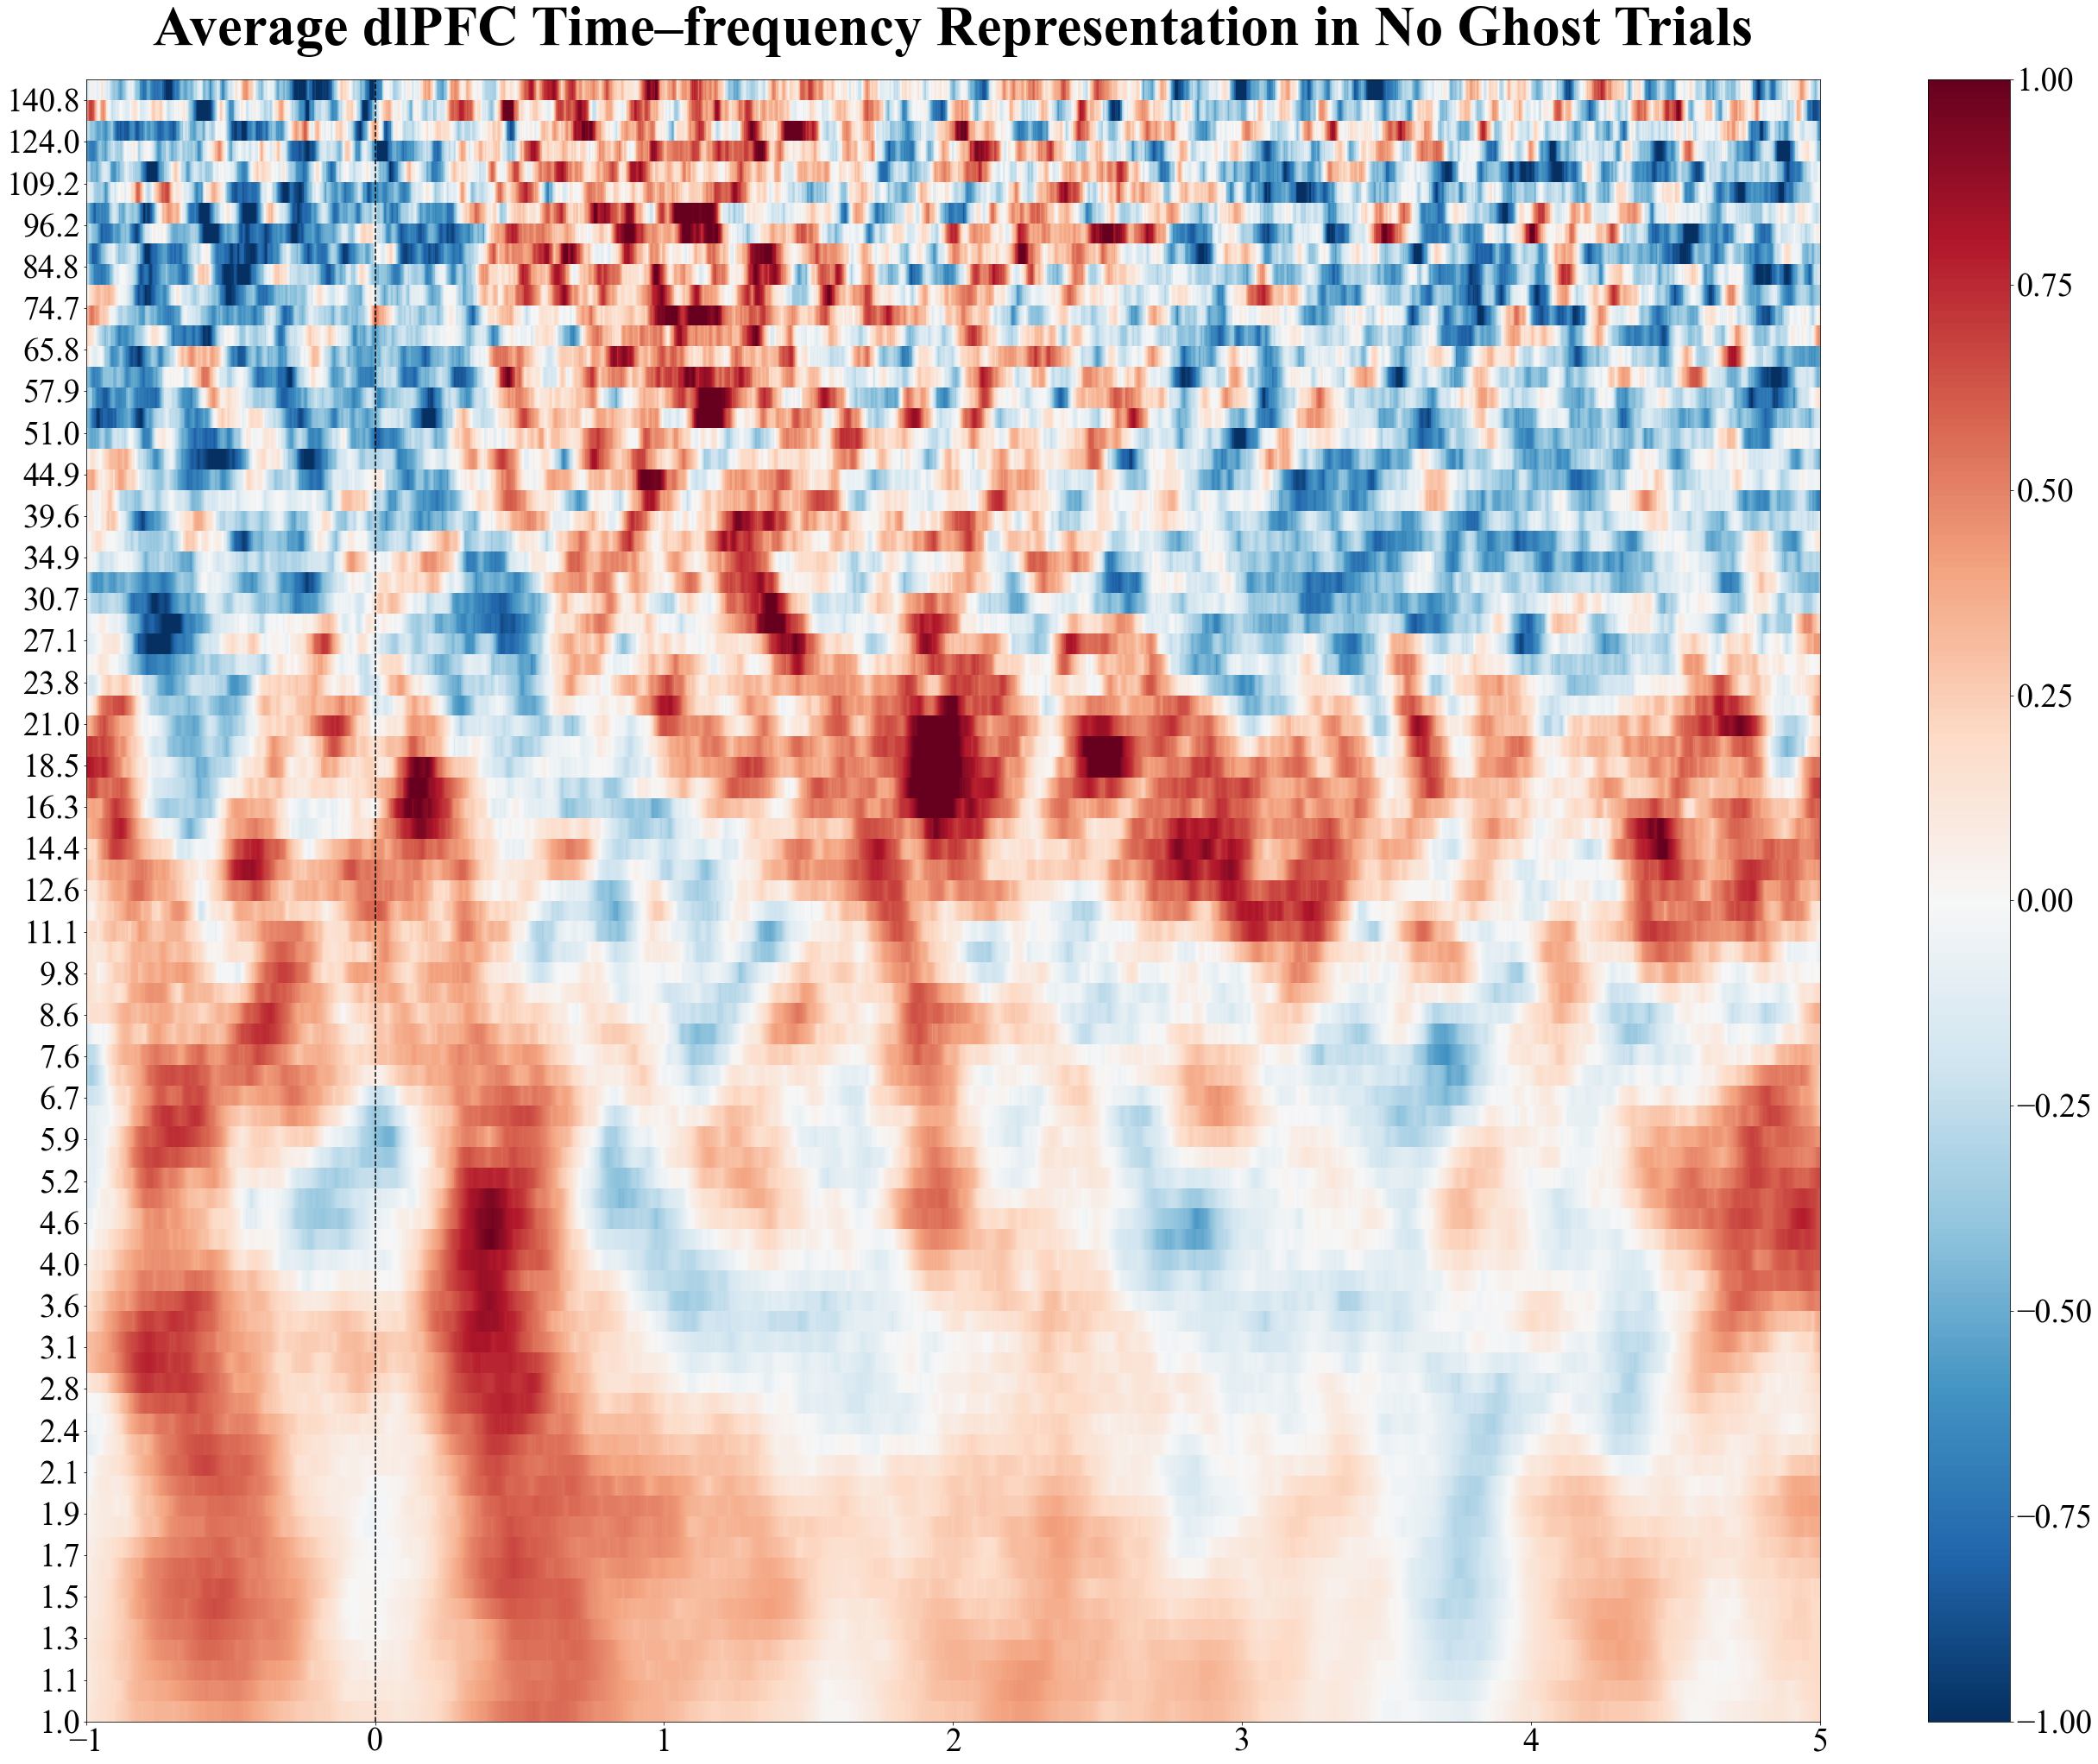

In [17]:
plot_allsub_averages(all_subs_average_dlpfc_noghost, "Average dlPFC Time–frequency Representation in No Ghost Trials", 'average_dlpfc_noghosttrialonset_all_subs.png')

## Insula

In [18]:
sub_list = ['SLCH002', 'BJH016', 'BJH021', 'LL12']

all_subs_average_insula_ghost = calculate_trial_onset_average(sub_list, 'TrialType <= 16', 'insula')
all_subs_average_insula_noghost = calculate_trial_onset_average(sub_list, 'TrialType > 16', 'insula')


Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/trial_onset/insula-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/BJH016/ieeg/trial_onset/insula-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/BJH021/ieeg/trial_onset/insula-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/LL12/ieeg/trial_onset/insula-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/trial_onset/insula-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/BJH016/ieeg/trial_onset/insula-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/BJH021/ieeg/trial_onset/insula-tfr

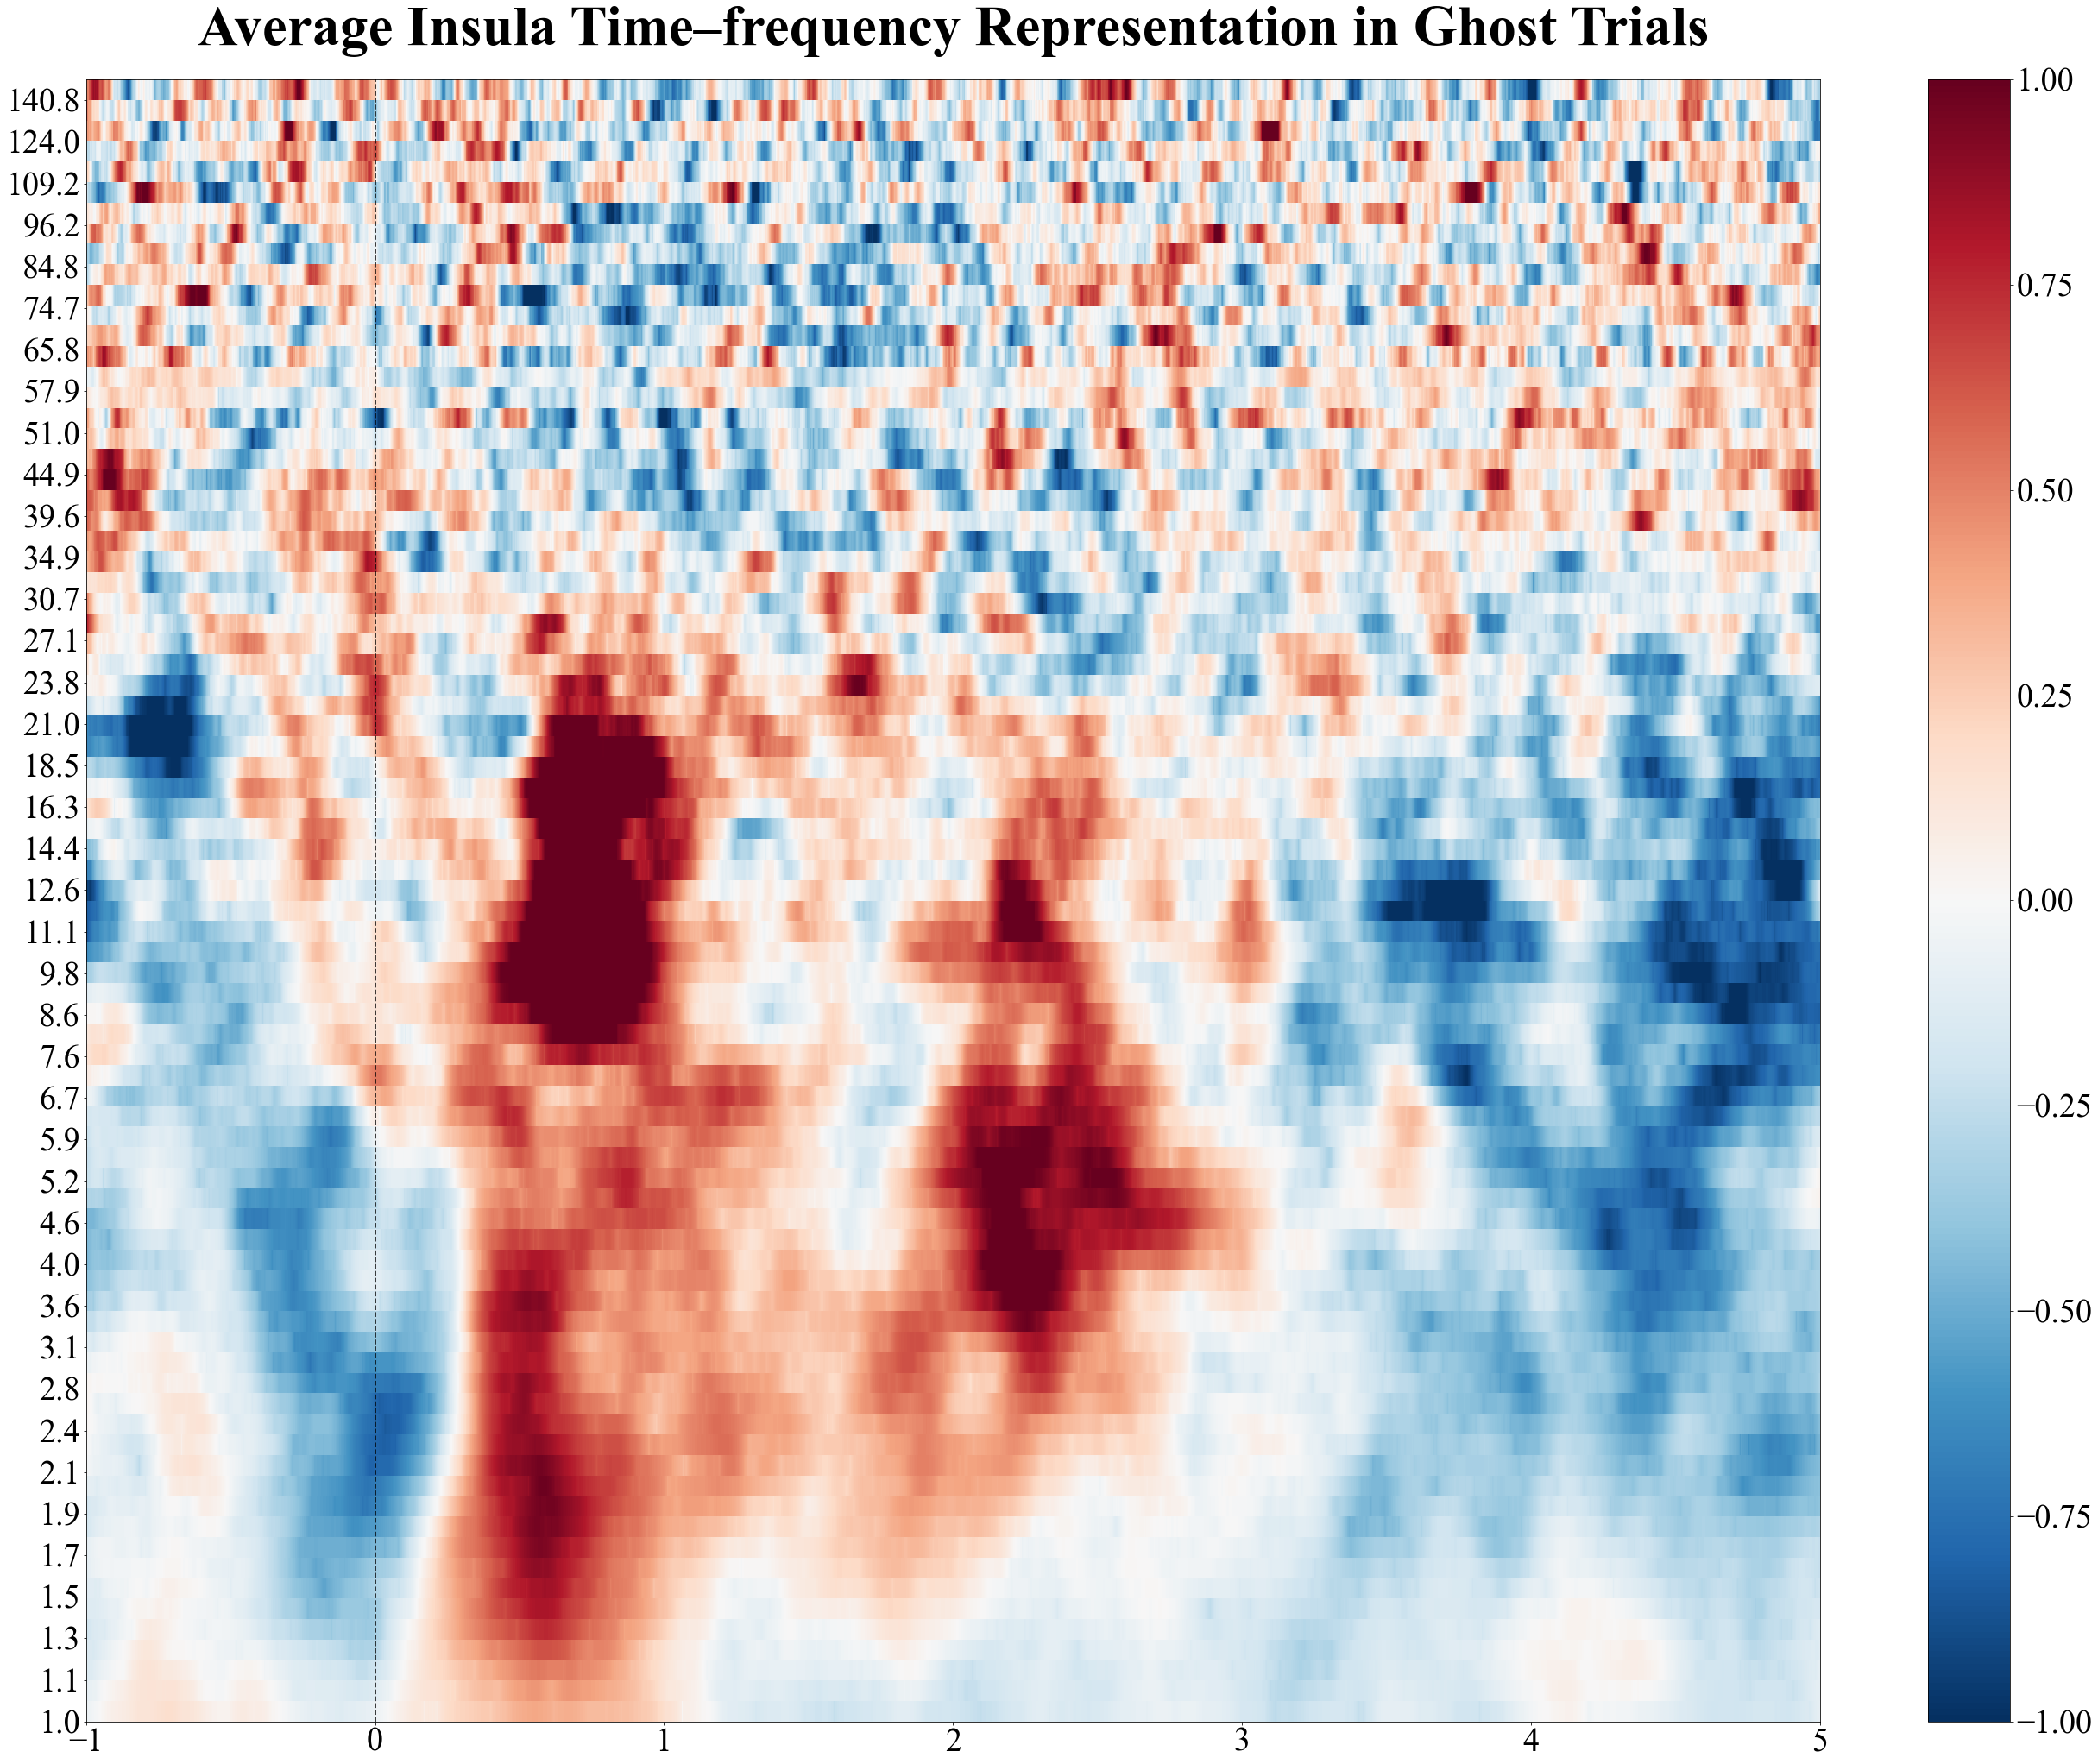

In [19]:
plot_allsub_averages(all_subs_average_insula_ghost, "Average Insula Time–frequency Representation in Ghost Trials", 'average_insula_ghosttrialonset_all_subs.png')

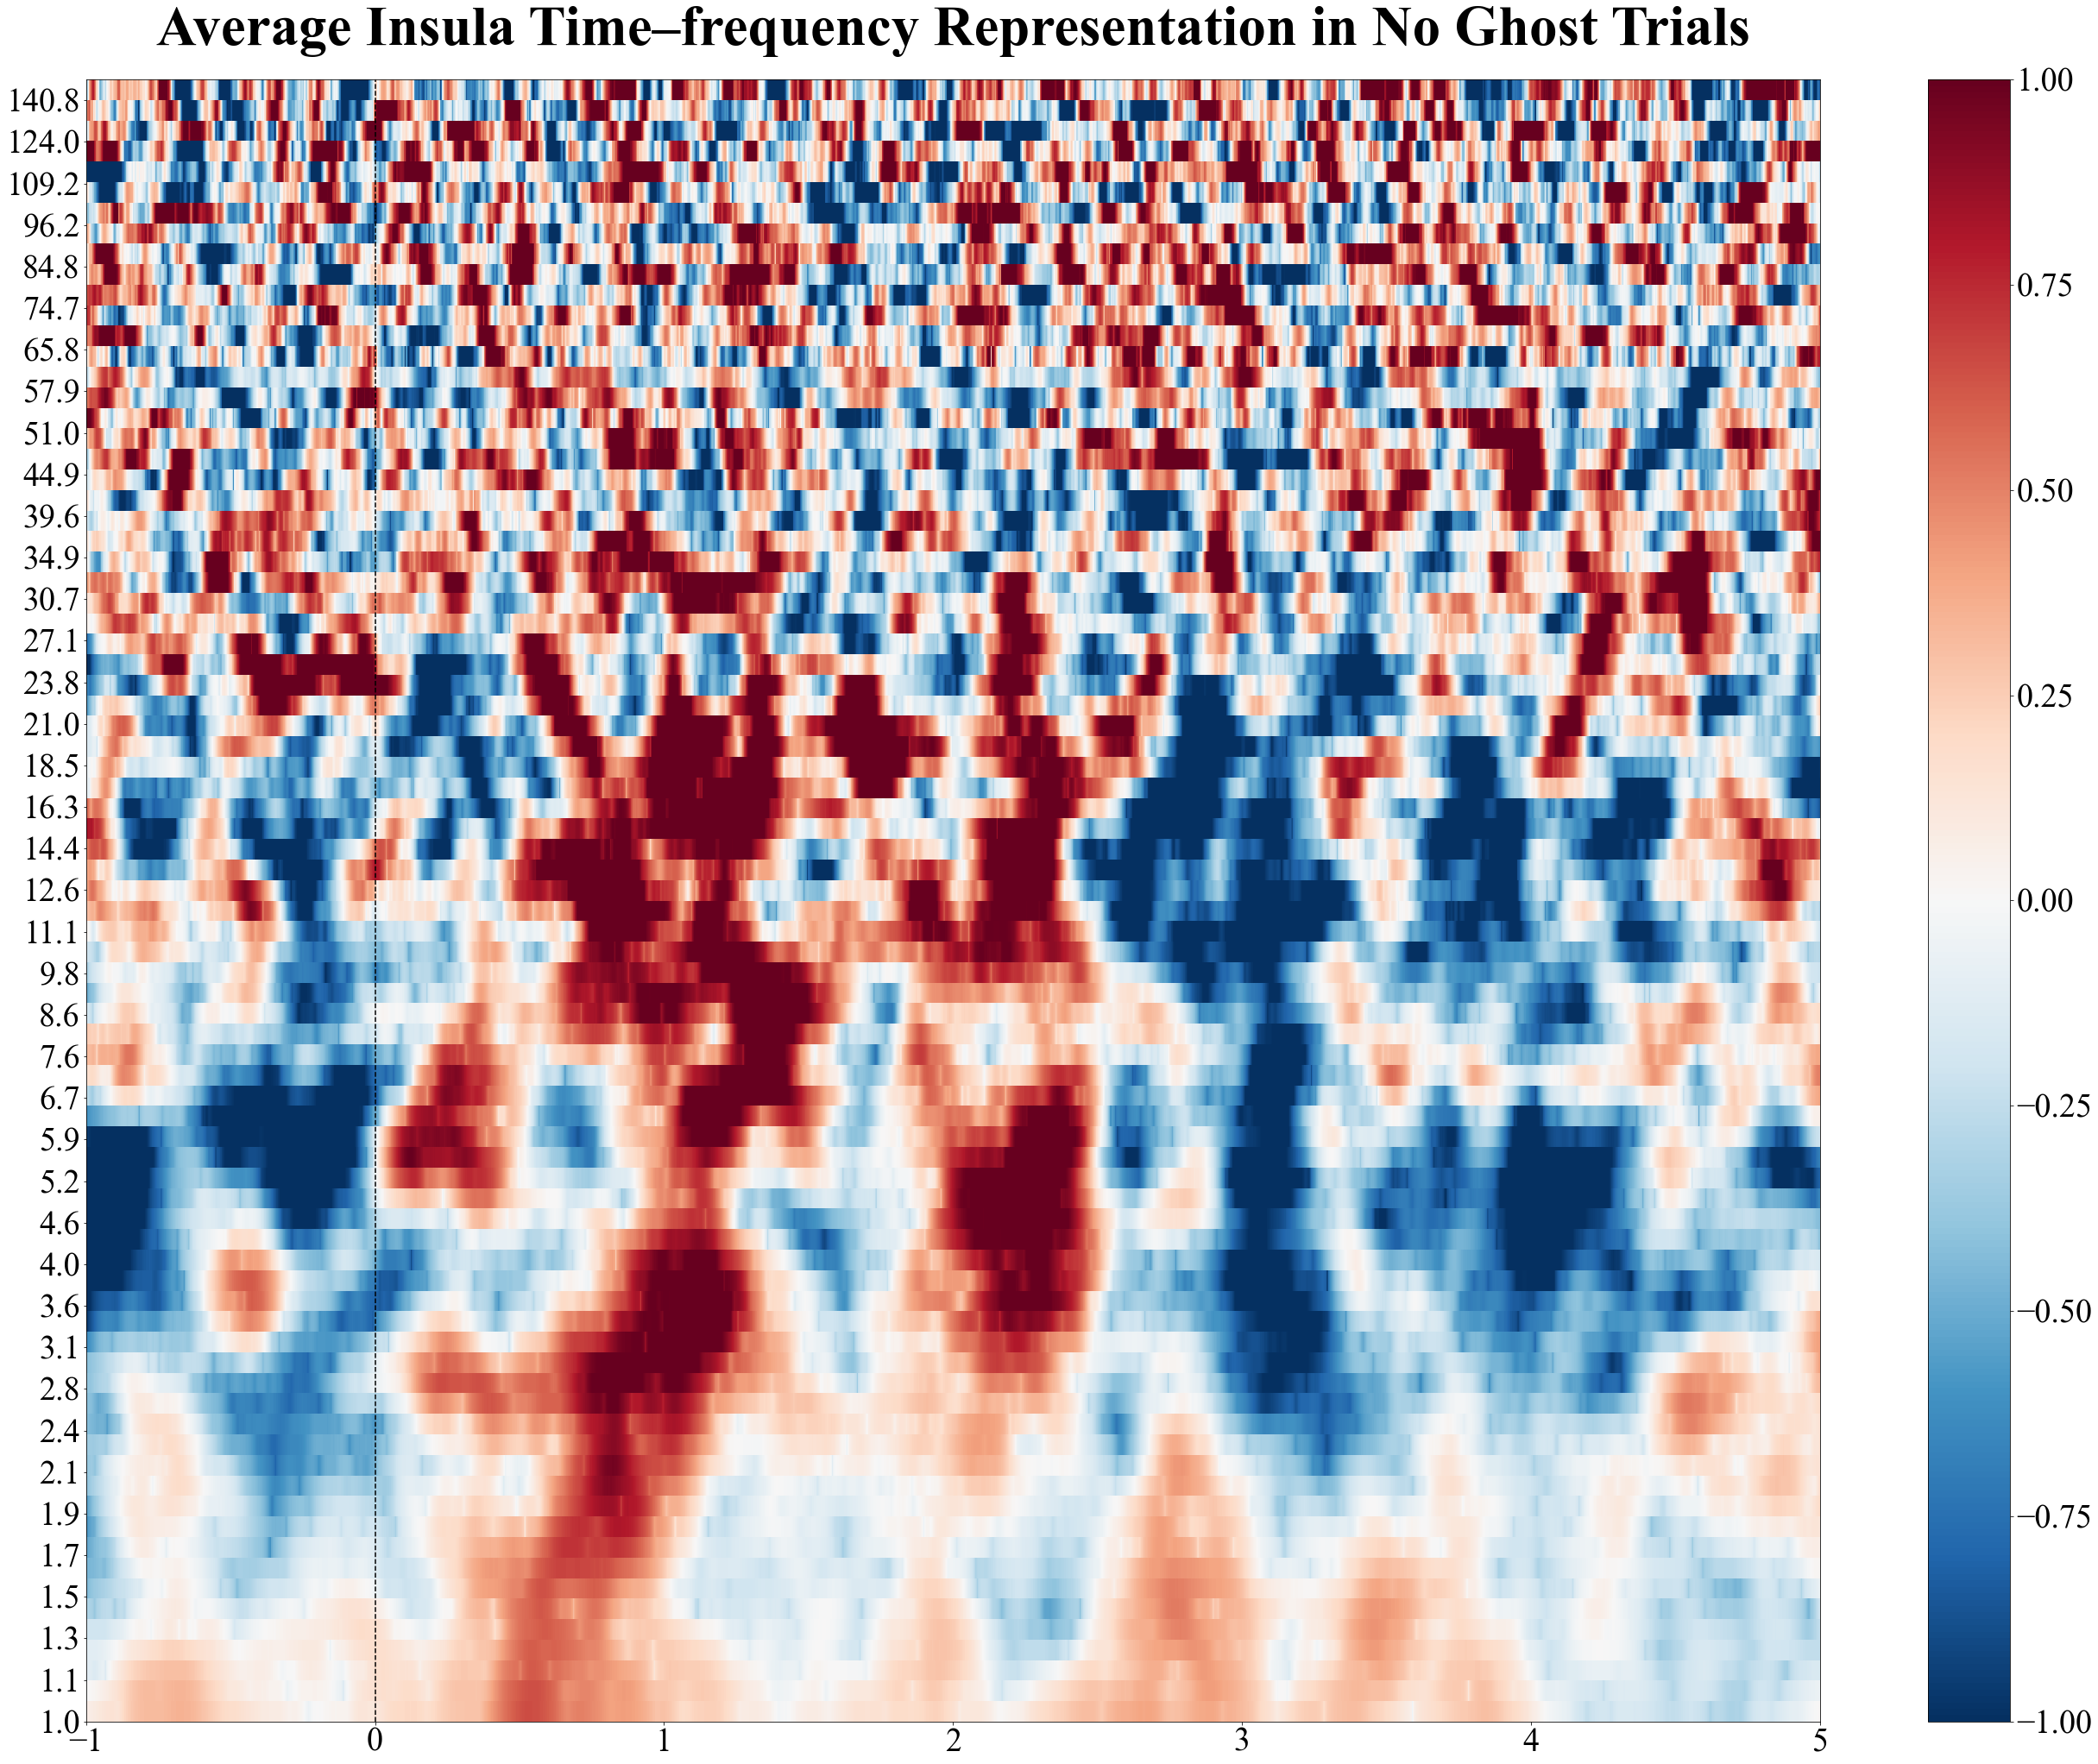

In [20]:
plot_allsub_averages(all_subs_average_insula_noghost, "Average Insula Time–frequency Representation in No Ghost Trials", 'average_insula_noghosttrialonset_all_subs.png')

## EC

In [21]:
sub_list = ['SLCH002', 'BJH016']

all_subs_average_ec_ghost = calculate_trial_onset_average(sub_list, 'TrialType <= 16', 'ec')
all_subs_average_ec_noghost = calculate_trial_onset_average(sub_list, 'TrialType > 16', 'ec')


Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/trial_onset/ec-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/BJH016/ieeg/trial_onset/ec-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/trial_onset/ec-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline
Reading /home/brooke/pacman/preprocessing/BJH016/ieeg/trial_onset/ec-tfr.h5 ...
Adding metadata with 2 columns
log transforming
z-scoring to baseline


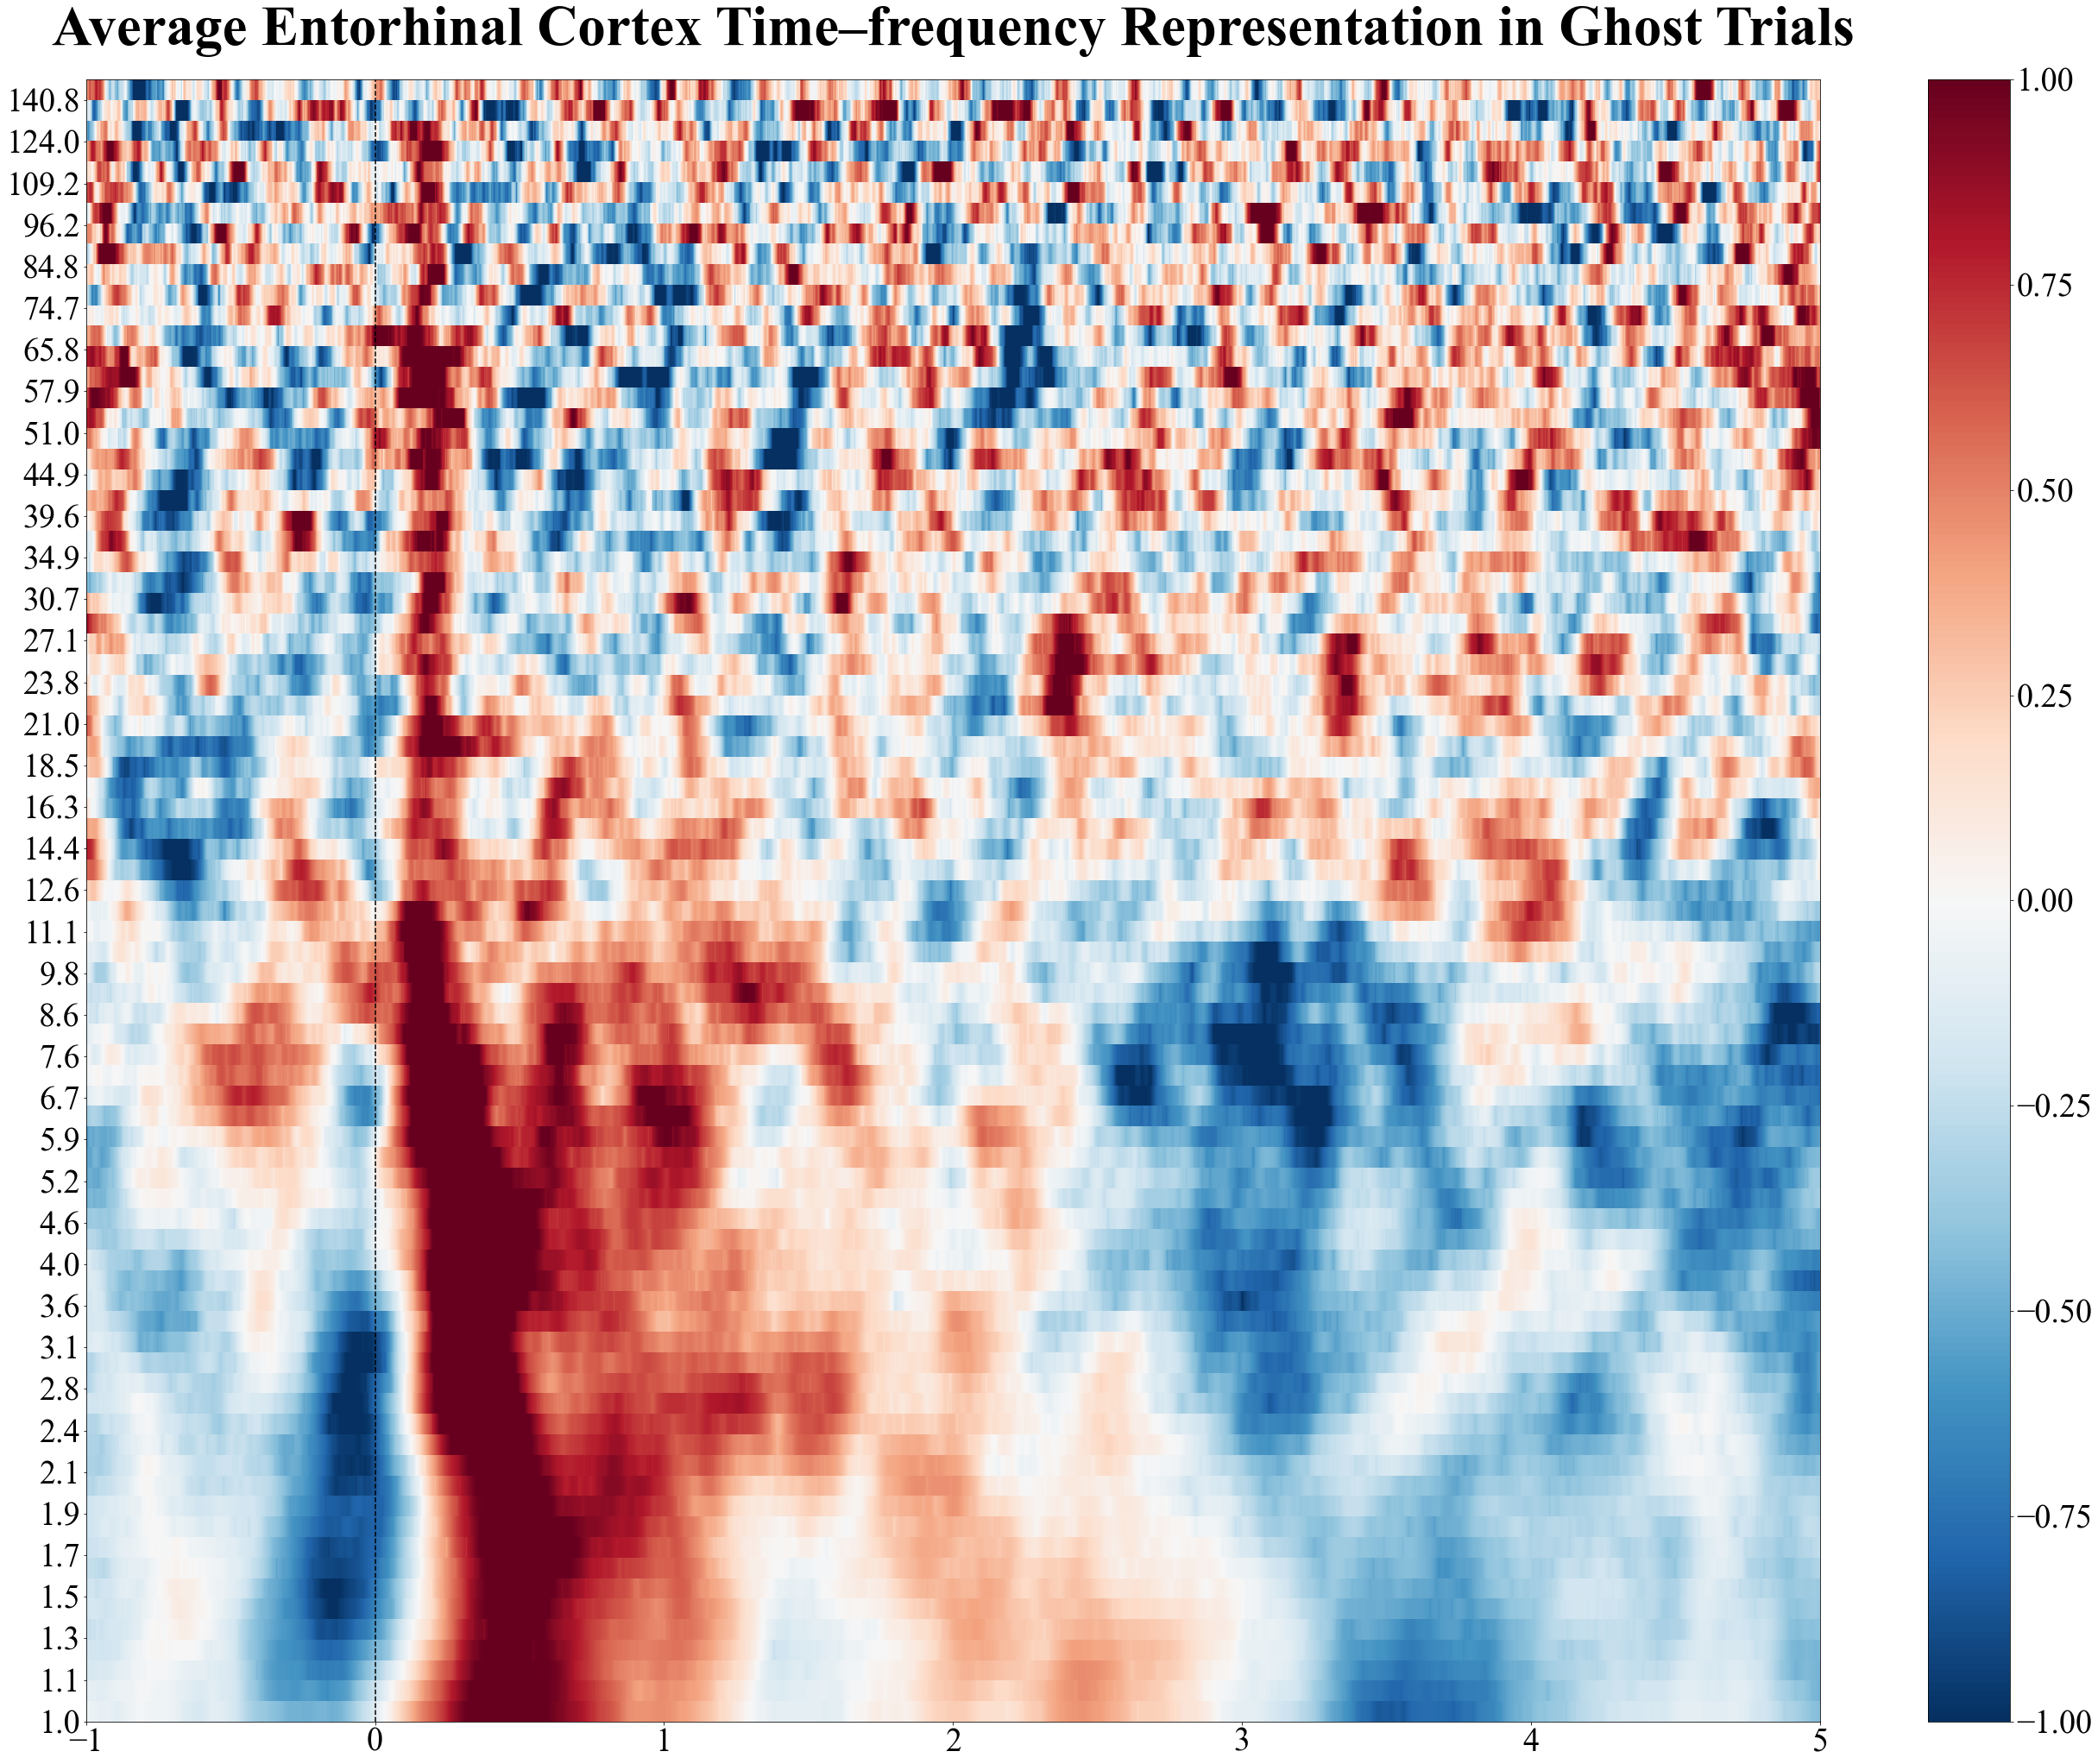

In [22]:
plot_allsub_averages(all_subs_average_ec_ghost, "Average Entorhinal Cortex Time–frequency Representation in Ghost Trials", 'average_ec_ghosttrialonset_all_subs.png')



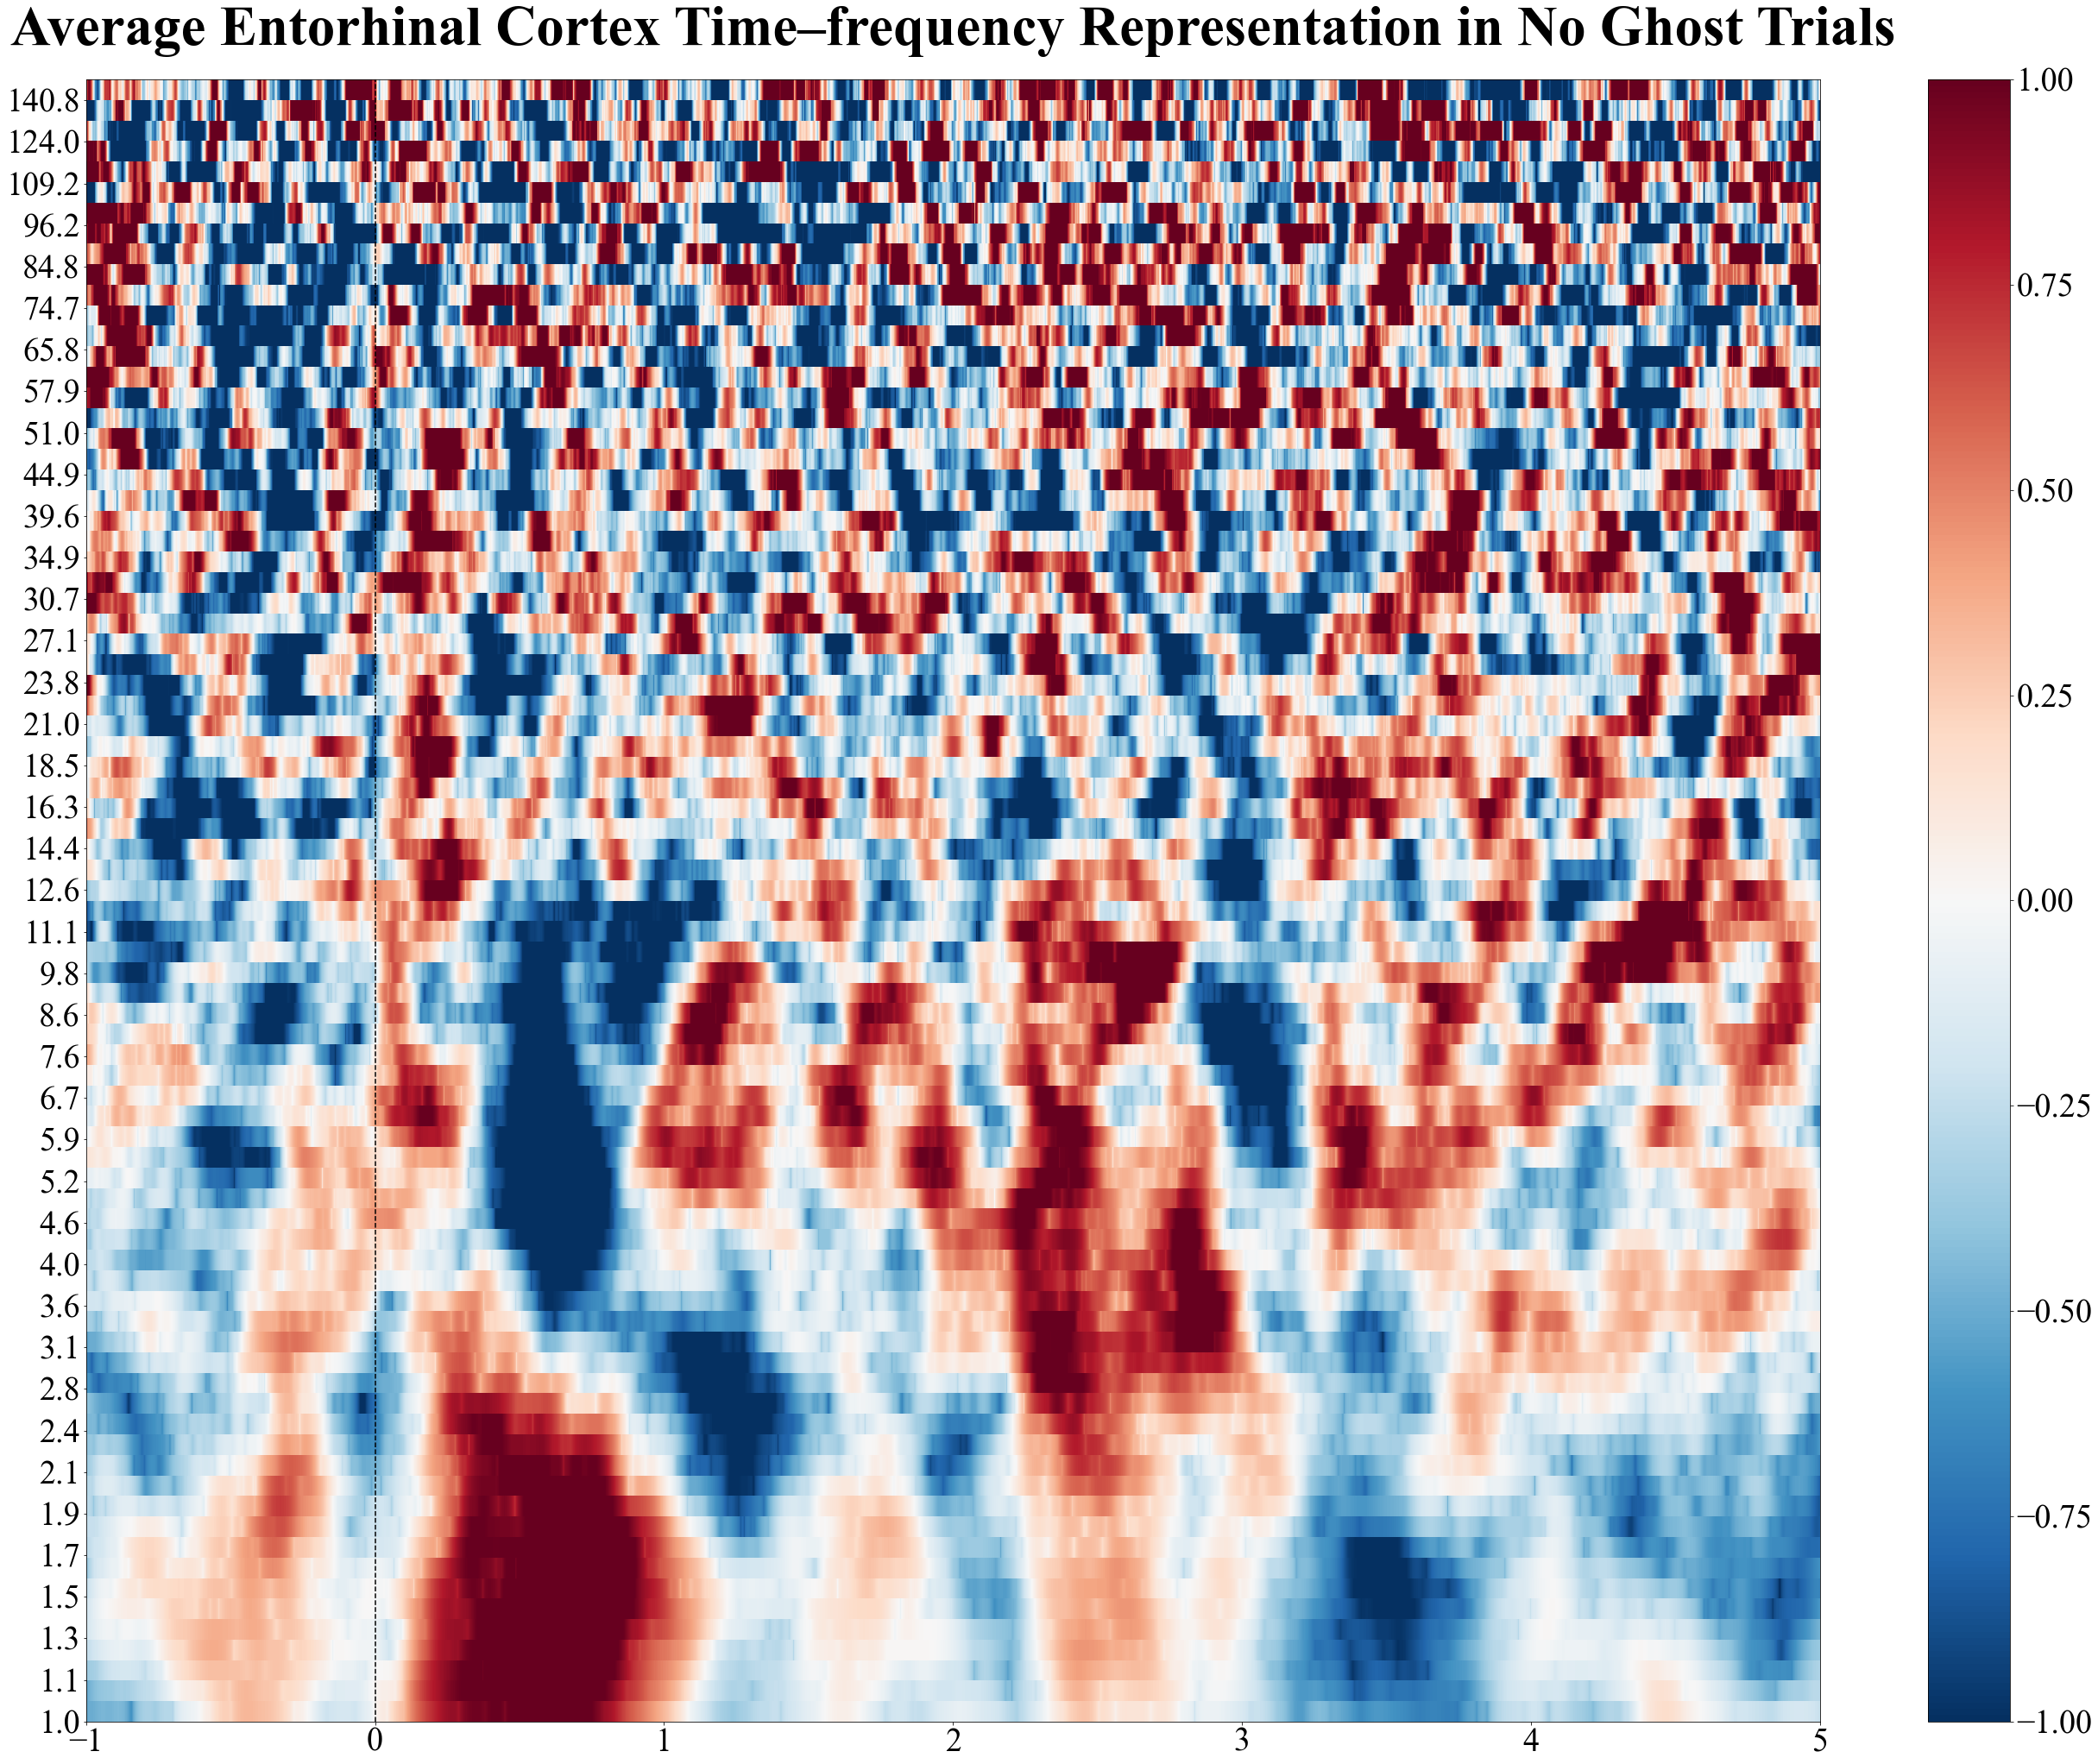

In [23]:
plot_allsub_averages(all_subs_average_ec_noghost, "Average Entorhinal Cortex Time–frequency Representation in No Ghost Trials", 'average_ec_noghosttrialonset_all_subs.png')